In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import networkx as nx
import mygene
import torch
import math

In [2]:
current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Data', 'RNA_dataset_tabular_R3.csv'))

# expression data
tabular_data = pd.read_csv(somepath, sep = ',', index_col = 0)
gene_data = tabular_data
gene_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,CD276,TIPARP,PFS_P,PFS_P_CNSR,MATH,HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA,PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA,CD8_POSITIVE_CELLS_TUMOR_CENTER,CD8_POSITIVE_CELLS_TOTAL_AREA,TRT01P
id,,,,,,,,,,,,,,,,,,,,,
X00936b9285d6b8665ae9122993fb8e91,6.10,4.38,3.07,6.14,4.70,7.52,4.93,8.37,6.21,5.69,...,7.09,4.94,4.172485,0,17.928391,70.0,0.0,0.08,0.1931,Avelumab+Axitinib
X105622fadc33f23755ac2df823110aca,5.07,3.33,1.73,5.11,5.62,6.58,4.34,7.42,6.15,4.86,...,6.56,4.61,16.591376,1,16.122090,85.0,1.0,0.12,0.1214,Sunitinib
Xe44f39747a8e84b02b4cb24659312144,6.13,4.41,3.23,6.32,5.57,8.02,5.14,7.55,6.87,6.27,...,7.14,8.42,11.104723,0,23.616637,80.0,5.0,0.92,0.9203,Sunitinib
X293dd1284496215e9a0eca9f17a98e7e,5.82,4.30,3.44,6.45,4.86,7.45,4.90,8.39,6.83,5.70,...,6.73,6.28,14.028747,1,24.817435,60.0,5.0,3.16,3.1635,Sunitinib
X01ed7190ce00862696edbf047b542045,6.15,4.21,3.90,5.93,4.43,7.60,4.74,8.31,6.38,5.94,...,6.66,4.93,12.418891,0,19.303863,80.0,2.0,1.98,2.0708,Sunitinib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xc3d410d70dd7359baa40126494fb6765,6.25,3.62,4.80,4.72,5.39,7.01,4.57,6.96,6.26,5.70,...,6.58,6.59,9.790554,1,24.552611,75.0,0.0,1.01,1.0089,Sunitinib
X50772aa64efb859960b20f8801cd6f58,6.27,3.78,3.98,5.95,4.66,7.18,4.61,8.04,6.62,5.80,...,6.74,5.48,4.271047,0,15.672304,75.0,1.0,1.10,1.1775,Sunitinib
X91bcd3067a1a7954692d836515e04869,6.12,3.94,3.25,6.09,4.98,7.32,5.02,8.21,6.71,5.89,...,7.59,7.59,2.496920,0,27.837848,50.0,1.0,4.03,3.9642,Sunitinib


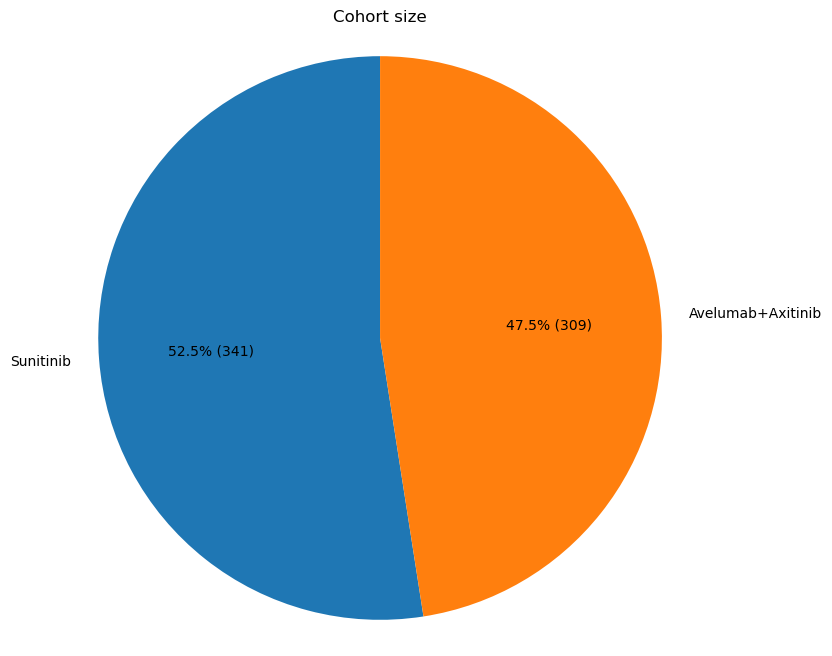

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming gene_data is your DataFrame and 'TRT01P' is the column name
# Replace 'gene_data' with the name of your DataFrame and 'TRT01P' with your column name

# Count the occurrences of each category in the 'TRT01P' column
category_counts = gene_data['TRT01P'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
category_counts.plot(kind='pie', autopct=lambda pct: f'{pct:.1f}% ({int(pct/100 * len(gene_data))})', startangle=90)
plt.title('Cohort size')
plt.ylabel('')  # Remove the y-label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [210]:
A = gene_data.iloc[0]
gene_data.drop(A.name)

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,CD276,TIPARP,PFS_P,PFS_P_CNSR,MATH,HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA,PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA,CD8_POSITIVE_CELLS_TUMOR_CENTER,CD8_POSITIVE_CELLS_TOTAL_AREA,TRT01P
id,,,,,,,,,,,,,,,,,,,,,
X105622fadc33f23755ac2df823110aca,5.07,3.33,1.73,5.11,5.62,6.58,4.34,7.42,6.15,4.86,...,6.56,4.61,16.591376,1,16.122090,85.0,1.0,0.12,0.1214,Sunitinib
Xe44f39747a8e84b02b4cb24659312144,6.13,4.41,3.23,6.32,5.57,8.02,5.14,7.55,6.87,6.27,...,7.14,8.42,11.104723,0,23.616637,80.0,5.0,0.92,0.9203,Sunitinib
X293dd1284496215e9a0eca9f17a98e7e,5.82,4.30,3.44,6.45,4.86,7.45,4.90,8.39,6.83,5.70,...,6.73,6.28,14.028747,1,24.817435,60.0,5.0,3.16,3.1635,Sunitinib
X01ed7190ce00862696edbf047b542045,6.15,4.21,3.90,5.93,4.43,7.60,4.74,8.31,6.38,5.94,...,6.66,4.93,12.418891,0,19.303863,80.0,2.0,1.98,2.0708,Sunitinib
Xf4a6a5a1450a8448882e1c0aebc0eea5,5.66,4.92,2.72,5.79,4.63,7.06,4.86,7.74,6.20,6.00,...,6.29,9.62,13.831622,1,41.634658,70.0,8.0,4.55,4.5501,Sunitinib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xc7439a06ffa32b313b0ec1b987b992a2,5.91,3.62,3.34,5.80,8.86,8.69,4.52,8.15,5.77,6.85,...,6.82,5.27,6.505133,1,26.606826,80.0,1.0,0.14,0.1417,Avelumab+Axitinib
X21a6043653d187f8bbead475d2f49791,6.48,4.32,2.27,6.10,5.13,7.83,5.18,8.34,6.70,6.02,...,7.98,5.24,5.683778,1,17.627516,70.0,0.0,3.10,3.1024,Sunitinib
650,6.10,4.38,3.07,6.14,4.70,7.52,4.93,8.37,6.21,5.69,...,7.09,4.94,4.172485,0,17.928391,70.0,0.0,0.08,0.1931,Avelumab+Axitinib


In [206]:
gene_data.loc[gene_data.iloc[0].name+ 'Z'] = gene_data.iloc[0]
gene_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,CD276,TIPARP,PFS_P,PFS_P_CNSR,MATH,HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA,PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA,CD8_POSITIVE_CELLS_TUMOR_CENTER,CD8_POSITIVE_CELLS_TOTAL_AREA,TRT01P
id,,,,,,,,,,,,,,,,,,,,,
X00936b9285d6b8665ae9122993fb8e91,6.10,4.38,3.07,6.14,4.70,7.52,4.93,8.37,6.21,5.69,...,7.09,4.94,4.172485,0,17.928391,70.0,0.0,0.08,0.1931,Avelumab+Axitinib
X105622fadc33f23755ac2df823110aca,5.07,3.33,1.73,5.11,5.62,6.58,4.34,7.42,6.15,4.86,...,6.56,4.61,16.591376,1,16.122090,85.0,1.0,0.12,0.1214,Sunitinib
Xe44f39747a8e84b02b4cb24659312144,6.13,4.41,3.23,6.32,5.57,8.02,5.14,7.55,6.87,6.27,...,7.14,8.42,11.104723,0,23.616637,80.0,5.0,0.92,0.9203,Sunitinib
X293dd1284496215e9a0eca9f17a98e7e,5.82,4.30,3.44,6.45,4.86,7.45,4.90,8.39,6.83,5.70,...,6.73,6.28,14.028747,1,24.817435,60.0,5.0,3.16,3.1635,Sunitinib
X01ed7190ce00862696edbf047b542045,6.15,4.21,3.90,5.93,4.43,7.60,4.74,8.31,6.38,5.94,...,6.66,4.93,12.418891,0,19.303863,80.0,2.0,1.98,2.0708,Sunitinib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xc7439a06ffa32b313b0ec1b987b992a2,5.91,3.62,3.34,5.80,8.86,8.69,4.52,8.15,5.77,6.85,...,6.82,5.27,6.505133,1,26.606826,80.0,1.0,0.14,0.1417,Avelumab+Axitinib
X21a6043653d187f8bbead475d2f49791,6.48,4.32,2.27,6.10,5.13,7.83,5.18,8.34,6.70,6.02,...,7.98,5.24,5.683778,1,17.627516,70.0,0.0,3.10,3.1024,Sunitinib
650,6.10,4.38,3.07,6.14,4.70,7.52,4.93,8.37,6.21,5.69,...,7.09,4.94,4.172485,0,17.928391,70.0,0.0,0.08,0.1931,Avelumab+Axitinib


In [42]:
gene_data = gene_data[gene_data['TRT01P'] == 'Sunitinib']
gene_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,CD276,TIPARP,PFS_P,PFS_P_CNSR,MATH,HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA,PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA,CD8_POSITIVE_CELLS_TUMOR_CENTER,CD8_POSITIVE_CELLS_TOTAL_AREA,TRT01P
id,,,,,,,,,,,,,,,,,,,,,
X105622fadc33f23755ac2df823110aca,5.07,3.33,1.73,5.11,5.62,6.58,4.34,7.42,6.15,4.86,...,6.56,4.61,16.591376,1,16.122090,85.0,1.0,0.12,0.1214,Sunitinib
Xe44f39747a8e84b02b4cb24659312144,6.13,4.41,3.23,6.32,5.57,8.02,5.14,7.55,6.87,6.27,...,7.14,8.42,11.104723,0,23.616637,80.0,5.0,0.92,0.9203,Sunitinib
X293dd1284496215e9a0eca9f17a98e7e,5.82,4.30,3.44,6.45,4.86,7.45,4.90,8.39,6.83,5.70,...,6.73,6.28,14.028747,1,24.817435,60.0,5.0,3.16,3.1635,Sunitinib
X01ed7190ce00862696edbf047b542045,6.15,4.21,3.90,5.93,4.43,7.60,4.74,8.31,6.38,5.94,...,6.66,4.93,12.418891,0,19.303863,80.0,2.0,1.98,2.0708,Sunitinib
Xf4a6a5a1450a8448882e1c0aebc0eea5,5.66,4.92,2.72,5.79,4.63,7.06,4.86,7.74,6.20,6.00,...,6.29,9.62,13.831622,1,41.634658,70.0,8.0,4.55,4.5501,Sunitinib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xa7d2bd80340b4019986ea8d8c3638c75,5.82,4.01,4.46,5.89,5.43,7.57,5.04,7.64,5.60,5.99,...,6.43,4.70,12.583162,1,26.364226,75.0,0.0,0.93,0.9281,Sunitinib
Xc3d410d70dd7359baa40126494fb6765,6.25,3.62,4.80,4.72,5.39,7.01,4.57,6.96,6.26,5.70,...,6.58,6.59,9.790554,1,24.552611,75.0,0.0,1.01,1.0089,Sunitinib
X50772aa64efb859960b20f8801cd6f58,6.27,3.78,3.98,5.95,4.66,7.18,4.61,8.04,6.62,5.80,...,6.74,5.48,4.271047,0,15.672304,75.0,1.0,1.10,1.1775,Sunitinib


In [44]:
# method that returns dict having K datasets, where the i+1 dataset is the ith dataset with the 1/K part shifted
allDatasets = {}
K = 3

df_copy = gene_data.copy(deep = True)

for i in range(K):
    print(i)
    lastRows = df_copy[(len(gene_data)//K)*(K-1):]
    df_copy = df_copy.drop(lastRows.index)
    df_copy = pd.concat([lastRows, df_copy])
    allDatasets[i] = df_copy

0
1
2


In [45]:
allDatasets[1]

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,CD276,TIPARP,PFS_P,PFS_P_CNSR,MATH,HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA,PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA,CD8_POSITIVE_CELLS_TUMOR_CENTER,CD8_POSITIVE_CELLS_TOTAL_AREA,TRT01P
id,,,,,,,,,,,,,,,,,,,,,
X461c081c2c3c0af3a9064fe5bc520214,6.31,4.73,2.27,6.66,5.42,7.91,5.59,8.37,7.20,5.87,...,6.43,4.46,1.445585,0,17.942293,75.0,3.0,11.57,11.5744,Sunitinib
Xa5a89e3b494c89531b85775c39b079bc,6.28,5.45,0.01,7.03,5.18,8.21,6.22,8.15,6.68,6.21,...,7.52,4.50,2.825462,0,19.079873,60.0,5.0,2.52,2.5221,Sunitinib
X2aa31f4365d2e06f42bc23886ce71799,6.25,4.09,3.98,6.01,4.88,7.80,4.79,8.24,6.16,5.78,...,6.61,4.95,8.377823,1,15.573529,80.0,2.0,2.39,2.3916,Sunitinib
X805f226a799d96e3e9e9511d5bd6202e,6.14,4.43,2.92,6.67,5.29,8.08,5.10,8.02,7.21,5.93,...,6.99,6.35,2.759754,0,9.398896,90.0,15.0,0.80,0.9848,Sunitinib
Xc646bb117ef7c10a0088395cac42ce55,6.47,4.03,3.83,6.22,4.78,7.52,5.05,7.45,7.05,5.97,...,6.57,5.18,0.032854,1,32.500345,80.0,5.0,1.65,4.0580,Sunitinib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X0f3ebb55cb792f27d6b89dfadc958636,6.25,4.16,3.63,6.22,4.63,7.41,5.06,9.49,6.51,5.73,...,7.42,5.85,2.858316,0,39.760636,60.0,7.0,1.87,1.8706,Sunitinib
Xb77bf2b3a4da17962117b81d2daf46a2,6.13,4.20,4.04,5.87,4.56,7.49,4.63,8.08,5.29,5.98,...,6.71,7.15,8.312115,1,12.147353,80.0,1.0,1.73,1.5261,Sunitinib
Xc89fc7348dd8c1385404fc2e54eb5dc8,6.14,4.42,2.95,6.09,4.44,7.72,4.73,9.06,6.43,5.81,...,7.26,9.84,8.114990,0,16.438209,75.0,8.0,1.64,2.0377,Sunitinib


In [62]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2
val_ratio = 0.1

A_indices = allDatasets[1][allDatasets[1]['PFS_P_CNSR'] == 0].index
B_indices = allDatasets[1][allDatasets[1]['PFS_P_CNSR'] == 1].index

A_train, A_temp = train_test_split(A_indices, test_size=test_ratio + val_ratio, random_state=42)
A_test, A_val = train_test_split(A_temp, test_size=val_ratio / (test_ratio + val_ratio), random_state=42)

# Splitting B_indices into training, testing, and validation sets
B_train, B_temp = train_test_split(B_indices, test_size=test_ratio + val_ratio, random_state=42)
B_test, B_val = train_test_split(B_temp, test_size=val_ratio / (test_ratio + val_ratio), random_state=42)

# Combining the sets
train_indices = list(A_train) + list(B_train)
test_indices = list(A_test) + list(B_test)
val_indices = list(A_val) + list(B_val)

# Creating the sets
train_set = tabular_data.loc[train_indices]
test_set = tabular_data.loc[test_indices]
val_set = tabular_data.loc[val_indices]

In [71]:
maxCnsr = max(test_set[test_set['PFS_P_CNSR'] == 0]['PFS_P'])

In [74]:
test_set[test_set['PFS_P_CNSR'] == 1]['PFS_P'] > maxCnsr

id
X5709f9e5805825fc3821f22c7b148137     True
X3b1ff3ab3d1f98e94f9966b350d2d64e    False
Xac45c5f63593fb9b54d73e75ec6dca7b    False
X0131ee30a1572f16c5674577f5cf6a43    False
Xd958f79f90ef2a70eaf9711208600728    False
Xd041787a5e525c2edaaa90a843640bb9    False
X111cb9fffc9fc55d838d097af1e3b727    False
X40f2f3210695eef9940acf149b2d96ae    False
Xbe78ca3c4574d60a753d70731a52bc0e    False
Xac23ea23d161c0a4894912f42b8e0b9b    False
X8224b875993f51494672ed5edf92ea3c    False
X94cd280620f5e23ebcc4a2122ed7e243    False
Xf248a96e9f28c80844e8c27fc86d3e4d    False
X105622fadc33f23755ac2df823110aca    False
Xd77c1f9d62e12082abb31e74d3c8d6df    False
X48c1d034956d2932857a406c8dd2f945    False
Xd1096f586abee776522c0b579dc5c77e    False
X56ba97ddae593a006b800fcb28bbecd4    False
X3abf2b9a9346c01d52c76ce5dede3980    False
Xee4eaa5d3cc7dfb5f7a692bda987550e    False
X36a5cb9019e6b2362a0135c1909a8570    False
Xe2f05dd9123c59886e6de8a27a9d7492    False
X4f91a5db5911b40d50c2cc4a5859c5cd    False
X193d13f

In [58]:
class CustomDataset():
    """
    This class is used to have all types of data in one place. For example, the entire train set can be housed
    within this class. This way when we need to merge genData and cliData together, it can be done easily, as well
    as checking the labels for later use.
    """
    def __init__(self, genData, cliData, labels):
        self.genData = genData
        self.cliData = cliData
        self.labels = labels

    def __len__(self):
        return len(self.genData)

    def __getitem__(self, idx):
        return self.genData[idx], self.cliData[idx], self.labels[idx]

In [3]:
cli_vars = ['PFS_P', 'PFS_P_CNSR', 'MATH', 'HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA', 'PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA', 'CD8_POSITIVE_CELLS_TUMOR_CENTER', 'CD8_POSITIVE_CELLS_TOTAL_AREA']
gene_data = tabular_data.drop(columns = cli_vars)

In [4]:
maxVal = max([x for L in gene_data.values for x in L])
X_normalized = gene_data / maxVal

In [5]:
X_normalized

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,SLC22A3,SPAG16,HTATIP2,SLC17A1,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP
id,,,,,,,,,,,,,,,,,,,,,
X00936b9285d6b8665ae9122993fb8e91,0.395078,0.283679,0.198834,0.397668,0.304404,0.487047,0.319301,0.542098,0.402202,0.368523,...,0.163860,0.281736,0.288212,0.289508,0.457902,0.338731,0.264249,0.562176,0.459197,0.319948
X105622fadc33f23755ac2df823110aca,0.328368,0.215674,0.112047,0.330959,0.363990,0.426166,0.281088,0.480570,0.398316,0.314767,...,0.371762,0.287565,0.308290,0.288212,0.479275,0.443005,0.183938,0.393782,0.424870,0.298575
Xe44f39747a8e84b02b4cb24659312144,0.397021,0.285622,0.209197,0.409326,0.360751,0.519430,0.332902,0.488990,0.444948,0.406088,...,0.300518,0.264249,0.299870,0.190415,0.431347,0.376295,0.269430,0.409974,0.462435,0.545337
X293dd1284496215e9a0eca9f17a98e7e,0.376943,0.278497,0.222798,0.417746,0.314767,0.482513,0.317358,0.543394,0.442358,0.369171,...,0.292746,0.306995,0.318653,0.053756,0.431995,0.341321,0.266839,0.451425,0.435881,0.406736
X01ed7190ce00862696edbf047b542045,0.398316,0.272668,0.252591,0.384067,0.286917,0.492228,0.306995,0.538212,0.413212,0.384715,...,0.127591,0.347798,0.361399,0.433938,0.422927,0.378238,0.281736,0.367228,0.431347,0.319301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xc3d410d70dd7359baa40126494fb6765,0.404793,0.234456,0.310881,0.305699,0.349093,0.454016,0.295984,0.450777,0.405440,0.369171,...,0.370466,0.457902,0.306995,0.448187,0.367228,0.488990,0.150259,0.155440,0.426166,0.426813
X50772aa64efb859960b20f8801cd6f58,0.406088,0.244819,0.257772,0.385363,0.301813,0.465026,0.298575,0.520725,0.428756,0.375648,...,0.312824,0.372409,0.360751,0.505829,0.470207,0.398316,0.227979,0.383420,0.436528,0.354922
X91bcd3067a1a7954692d836515e04869,0.396373,0.255181,0.210492,0.394430,0.322539,0.474093,0.325130,0.531736,0.434585,0.381477,...,0.199482,0.313472,0.338731,0.000648,0.413212,0.336788,0.262306,0.507772,0.491580,0.491580


In [21]:
tabular_data.loc['X13181576c8d17b661499a05d62cc4355']['PFS_P']

12.45174538

In [25]:
nfkb1 = 0.4061
tnip2 = 0.2675
tmp = ((X_normalized['NFKB1'] <= nfkb1 + 0.0005) & (X_normalized['NFKB1'] >= nfkb1 - 0.0005) &
        (X_normalized['TNIP2'] <= tnip2 + 0.0005) & (X_normalized['TNIP2'] >= tnip2 - 0.0005))
true_indices = tmp[tmp].index

print(tabular_data.loc[true_indices[0]]['PFS_P'],
tabular_data.loc[true_indices[0]]['PFS_P_CNSR'])

20.79671458 1.0


In [26]:
max(X_normalized['TNIP2'])

0.3944300518134715

In [77]:
from torch.utils.data import Dataset, DataLoader

torch_tensor = torch.tensor(X_normalized.values)

data = CustomDataset(torch_tensor, torch_tensor, torch_tensor)

batch_size = 64
train_loader = list(DataLoader(data, batch_size=batch_size, shuffle=False))

In [86]:
X = list(train_loader)
res = []
for x in X:
    for b in x[0]:
        res += [b]
z = DataLoader(res, batch_size = len(res))

In [87]:
for i in z:
    print(i)

tensor([[0.3951, 0.2837, 0.1988,  ..., 0.5622, 0.4592, 0.3199],
        [0.3284, 0.2157, 0.1120,  ..., 0.3938, 0.4249, 0.2986],
        [0.3970, 0.2856, 0.2092,  ..., 0.4100, 0.4624, 0.5453],
        ...,
        [0.3964, 0.2552, 0.2105,  ..., 0.5078, 0.4916, 0.4916],
        [0.3828, 0.2345, 0.2163,  ..., 0.4411, 0.4417, 0.3413],
        [0.4197, 0.2798, 0.1470,  ..., 0.4339, 0.5168, 0.3394]],
       dtype=torch.float64)


In [29]:
dim = 0

slices = [tensor for tensor in train_loader]

# Extract slices along the specified dimension
#slices = [tensor[dim] for tensor in loader_lists]

# Flatten the slices
flattened_slices = [item for sublist in slices for item in sublist]

len0 = len(flattened_slices)
len1 = len(flattened_slices[0])

stacked_tensor = torch.stack(flattened_slices)
reshaped_tensor = stacked_tensor.reshape(len0, len1)
reshaped_tensor

tensor([[0.3951, 0.2837, 0.1988,  ..., 0.5622, 0.4592, 0.3199],
        [0.3284, 0.2157, 0.1120,  ..., 0.3938, 0.4249, 0.2986],
        [0.3970, 0.2856, 0.2092,  ..., 0.4100, 0.4624, 0.5453],
        ...,
        [0.3964, 0.2552, 0.2105,  ..., 0.5078, 0.4916, 0.4916],
        [0.3828, 0.2345, 0.2163,  ..., 0.4411, 0.4417, 0.3413],
        [0.4197, 0.2798, 0.1470,  ..., 0.4339, 0.5168, 0.3394]],
       dtype=torch.float64)

In [57]:
res = []

dim = 0
slices = [tensor[dim] for tensor in train_loader]

for tensor in train_loader:
    slice = tensor[dim]
    print(len(slice))
    res.append(slice)

res

2866
2866
2866
2866
2866
2866
2866
2866
2866
2866
2866


[tensor([0.3951, 0.2837, 0.1988,  ..., 0.5622, 0.4592, 0.3199],
        dtype=torch.float64),
 tensor([0.3763, 0.2979, 0.2260,  ..., 0.4624, 0.5097, 0.2947],
        dtype=torch.float64),
 tensor([0.3821, 0.3219, 0.0913,  ..., 0.5071, 0.5272, 0.3595],
        dtype=torch.float64),
 tensor([0.3925, 0.2863, 0.1516,  ..., 0.3549, 0.4605, 0.3549],
        dtype=torch.float64),
 tensor([0.3873, 0.3135, 0.1930,  ..., 0.4495, 0.4223, 0.5933],
        dtype=torch.float64),
 tensor([0.3834, 0.2902, 0.1665,  ..., 0.4365, 0.4275, 0.3582],
        dtype=torch.float64),
 tensor([0.4016, 0.2947, 0.2066,  ..., 0.5317, 0.5350, 0.3180],
        dtype=torch.float64),
 tensor([0.3815, 0.3316, 0.1826,  ..., 0.4819, 0.5032, 0.4255],
        dtype=torch.float64),
 tensor([0.3808, 0.2688, 0.2895,  ..., 0.4223, 0.4709, 0.2824],
        dtype=torch.float64),
 tensor([0.4197, 0.3141, 0.2655,  ..., 0.3627, 0.4722, 0.3180],
        dtype=torch.float64),
 tensor([0.3905, 0.2856, 0.2753,  ..., 0.3938, 0.4585, 0.341

In [30]:
len(reshaped_tensor)

650

In [30]:
len(train_loader)

11

In [31]:
len(list(train_loader))

11

In [34]:
for i, batch in enumerate(train_loader):
    if i == 0:
        print(batch)

tensor([[0.3951, 0.2837, 0.1988,  ..., 0.5622, 0.4592, 0.3199],
        [0.3284, 0.2157, 0.1120,  ..., 0.3938, 0.4249, 0.2986],
        [0.3970, 0.2856, 0.2092,  ..., 0.4100, 0.4624, 0.5453],
        ...,
        [0.3731, 0.2675, 0.2202,  ..., 0.5019, 0.4780, 0.3905],
        [0.3990, 0.2966, 0.2053,  ..., 0.5259, 0.4864, 0.3154],
        [0.4113, 0.2940, 0.1801,  ..., 0.3549, 0.4016, 0.5415]],
       dtype=torch.float64)


In [16]:
# Calculate the third quartile (Q3) for each column
q3_values = gene_data.quantile(0.75)

# Filter columns based on Q3 values less than 1
filtered_gene_data = gene_data.loc[:, (q3_values <= 2) | (gene_data.median() <= 1)]
filtered_gene_data

,A1BG-AS1,A2ML1,A3GALT2,A4GNT,AADAC,AADACL2,AADACL3,AADACL4,AANAT,AARD,...,ZSCAN10,ZSCAN12P1,ZSCAN16-AS1,ZSCAN22,ZSCAN23,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM2,ZYG11A
X00936b9285d6b8665ae9122993fb8e91,2.41,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,1.68,0.79,1.69,0.01,1.74,0.01,0.01,0.01
X105622fadc33f23755ac2df823110aca,0.71,0.01,0.70,0.01,7.96,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,1.31,0.98,0.01,0.01,1.16,0.01,0.01,1.32
Xe44f39747a8e84b02b4cb24659312144,2.48,0.01,1.37,0.01,1.79,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,1.66,1.72,2.01,0.01,2.03,0.01,0.01,0.01
X293dd1284496215e9a0eca9f17a98e7e,0.69,0.01,0.49,1.62,1.17,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,2.12,1.45,2.20,0.01,1.27,0.01,0.01,0.43
X01ed7190ce00862696edbf047b542045,1.83,0.01,0.27,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,1.76,1.52,0.21,0.01,1.73,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xc3d410d70dd7359baa40126494fb6765,0.01,0.01,0.01,0.60,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,1.64,0.15,2.36,0.01,1.72,0.01,0.01,3.40
X50772aa64efb859960b20f8801cd6f58,0.16,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,1.60,1.19,1.43,0.01,1.93,0.01,0.01,3.30
X91bcd3067a1a7954692d836515e04869,1.16,0.01,1.35,0.01,6.44,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,1.35,1.70,2.22,0.01,1.82,0.01,0.01,0.01
Xc7439a06ffa32b313b0ec1b987b992a2,0.56,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,1.89,1.78,2.08,0.01,2.38,0.01,0.01,0.21


In [8]:
filtered_gene_data.count()

NFKB1                                      650
TNIP2                                      650
AMOT                                       650
VASP                                       650
SS18L1                                     650
                                          ... 
MATH                                       650
HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA        650
PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA    650
CD8_POSITIVE_CELLS_TUMOR_CENTER            650
CD8_POSITIVE_CELLS_TOTAL_AREA              650
Length: 2953, dtype: int64

In [3]:
filtered_gene_data = gene_data

(0.0, 30.0)

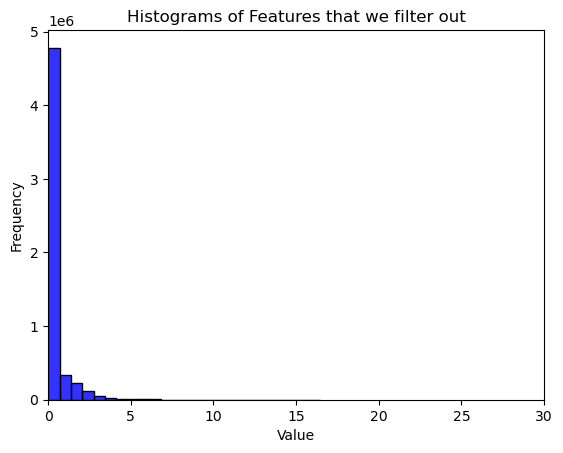

In [17]:
all_values = pd.concat([filtered_gene_data[col] for col in filtered_gene_data.columns])
X = all_values.values

sns.histplot(X, kde=False, alpha=.8, color='blue')
plt.title('Histograms of Features that we filter out')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(0, 30)  # Adjust the x-axis limits

----------------

In [8]:
idxs = [0,1,2]
vals = tabular_data.values
data_points = [x for idx in idxs for x in [vals[idx]]]
data_points2 = [list(values) for values in zip(*data_points)]

In [14]:
vals[:, idxs]

array([[6.1 , 4.38, 3.07],
       [5.07, 3.33, 1.73],
       [6.13, 4.41, 3.23],
       ...,
       [5.91, 3.62, 3.34],
       [6.48, 4.32, 2.27],
       [5.76, 4.79, 3.19]])

In [121]:
X = tabular_data.drop(['PFS', 'CENSOR'], axis = 1)
maxVal = max([x for L in X.values for x in L])
X_normalized = X / maxVal

X_normalized['PFS'] = tabular_data['PFS']
X_normalized['CENSOR'] = tabular_data['CENSOR']

return X_normalized


,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,SLC17A1,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP,WNT16,PFS,CENSOR
id,,,,,,,,,,,,,,,,,,,,,
X105622fadc33f23755ac2df823110aca,0.324792,0.213325,0.110826,0.327354,0.360026,0.421525,0.278027,0.475336,0.393978,0.311339,...,0.285074,0.474055,0.438181,0.181935,0.389494,0.420243,0.295324,0.000641,16.591376,1.0
X293dd1284496215e9a0eca9f17a98e7e,0.372838,0.275464,0.220372,0.413197,0.311339,0.477258,0.313901,0.537476,0.437540,0.365151,...,0.053171,0.427290,0.337604,0.263933,0.446509,0.431134,0.402306,0.000641,14.028747,1.0
Xf4a6a5a1450a8448882e1c0aebc0eea5,0.362588,0.315183,0.174247,0.370916,0.296605,0.452274,0.311339,0.495836,0.397181,0.384369,...,0.328635,0.435618,0.376041,0.240231,0.500320,0.402947,0.616272,0.000641,13.831622,1.0
Xf7ee4a331a8fd70edc240dff978c170d,0.413837,0.281871,0.178732,0.419603,0.305573,0.499680,0.323511,0.490711,0.435618,0.387572,...,0.174247,0.445868,0.405509,0.292120,0.368354,0.429212,0.355541,0.000641,13.897331,1.0
Xff8fbe2fe76c82d429d4fa1d315f3b93,0.397181,0.300448,0.164638,0.400384,0.309417,0.512492,0.324151,0.533632,0.401666,0.370916,...,0.373479,0.414478,0.362588,0.251121,0.419603,0.422165,0.306214,0.000641,11.203285,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X50772aa64efb859960b20f8801cd6f58,0.401666,0.242152,0.254965,0.381166,0.298527,0.459962,0.295324,0.515054,0.424087,0.371557,...,0.500320,0.465086,0.393978,0.225496,0.379244,0.431775,0.351057,0.000641,4.271047,0.0
X91bcd3067a1a7954692d836515e04869,0.392056,0.252402,0.208200,0.390135,0.319026,0.468930,0.321589,0.525945,0.429853,0.377322,...,0.000641,0.408712,0.333120,0.259449,0.502242,0.486227,0.486227,0.000641,2.496920,0.0
Xc7439a06ffa32b313b0ec1b987b992a2,0.378603,0.231903,0.213965,0.371557,0.567585,0.556694,0.289558,0.522101,0.369635,0.438821,...,0.468290,0.433056,0.456118,0.208200,0.436259,0.436899,0.337604,0.000641,6.505133,1.0


In [88]:
A = tabular_data[tabular_data['CENSOR'] == 0].index
B = tabular_data[tabular_data['CENSOR'] == 1].index
Idxs = []

size = len(tabular_data)
lengths = (0.7, 0.2, 0.1)

step = max(math.ceil(len(B) / len(A)), 1)
print(step)

i = 0
a = 0
b = 0
for l in lengths:
    tmp = []
    tmp_i = i
    while (i < tmp_i + int(size*l)):
        if ((i % step == 0 and a < len(A)) or (b >= len(B))):
            tmp.append(A[a])
            a += 1
        else:
            tmp.append(B[b])
            b += 1
        i += 1
    Idxs += [tmp]

train, test, val = tabular_data.loc[Idxs[0]], tabular_data.loc[Idxs[1]], tabular_data.loc[Idxs[2]]

2


In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming tabular_data is your DataFrame
A_indices = tabular_data[tabular_data['CENSOR'] == 0].index
B_indices = tabular_data[tabular_data['CENSOR'] == 1].index

# Splitting A_indices into training, testing, and validation sets
A_train, A_temp = train_test_split(A_indices, test_size=0.3, random_state=42)
A_test, A_val = train_test_split(A_temp, test_size=0.1/0.3, random_state=42)

# Splitting B_indices into training, testing, and validation sets
B_train, B_temp = train_test_split(B_indices, test_size=0.3, random_state=42)
B_test, B_val = train_test_split(B_temp, test_size=0.1/0.3, random_state=42)

# Combining the sets
train_indices = list(A_train) + list(B_train)
test_indices = list(A_test) + list(B_test)
val_indices = list(A_val) + list(B_val)

# Creating the sets
train_set = tabular_data.loc[train_indices]
test_set = tabular_data.loc[test_indices]
val_set = tabular_data.loc[val_indices]


In [72]:
step = max(len(B) // len(A), 1) + 1
step

2

In [101]:
train_set['CENSOR'].value_counts()

CENSOR
1.0    257
0.0    180
Name: count, dtype: int64

In [102]:
test_set['CENSOR'].value_counts()

CENSOR
1.0    73
0.0    51
Name: count, dtype: int64

In [103]:
val_set['CENSOR'].value_counts()

CENSOR
1.0    38
0.0    27
Name: count, dtype: int64

-------------------

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()

X = tabular_data.drop(columns=['PFS'])
Y = tabular_data['PFS']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns, index = X_test.index)

Y_train

id
Xf7ee4a331a8fd70edc240dff978c170d    13.897331
X5cabb9f0afcc6ec89f28a72e66b75c5b     3.909651
X2069a43cf26725e339dae5a64490a17f     1.379877
X3cdb45cfe9ffaac83f36c75e4af759e6     3.745380
X8783adc097e910b52c11f50e2a4aff2a     9.626283
                                       ...    
Xe1b0f87c25889df31bc0fe76a68853b6    12.517454
X502dfff1180e1952d964196c8493633b     0.032854
Xfdb742505b30978af60b426c93a32f9e     5.585216
X5db2ba740f908fe3a3e6832d48949346     1.412731
X490b3aaf0b34d71712e894ca670bff00     7.030801
Name: PFS, Length: 580, dtype: float64

In [34]:
torch.tensor(Y_train.values)

tensor([13.8973,  3.9097,  1.3799,  3.7454,  9.6263, 19.3511,  6.8994,  8.5749,
         1.6099,  6.9651,  5.6509,  4.2382,  2.5626,  8.4107,  1.2485,  1.4127,
         7.1622,  4.2053,  6.9322,  8.3121,  7.0308,  8.3450,  8.3450,  6.9322,
        12.3203,  1.4127,  0.4928,  1.4127, 11.3018,  2.8583,  1.4127,  8.2464,
         4.1725,  6.9322,  0.0329,  4.1725,  6.8994,  8.1150, 13.8316, 18.0041,
        16.6571,  2.8583,  4.1725,  1.4127,  4.4353,  5.4209, 10.8419,  2.7926,
         1.4127,  3.0226,  5.8480,  6.7680, 11.0719,  8.0493,  2.9240,  2.6283,
        14.0616, 12.6160,  2.7926, 12.2546,  5.5524,  4.2053,  6.9322,  6.9322,
         8.3121,  8.3121,  5.6181, 12.5832,  4.8296,  4.1396,  9.9220,  4.1068,
         8.3778, 11.1704,  4.1725,  8.3121,  1.4456,  5.6181, 20.7967,  3.2526,
        13.8645,  1.5113,  1.4456,  9.6591,  9.6920,  9.7577, 12.4517, 15.3101,
         9.6920,  5.7823,  7.7207,  7.0965,  9.5934, 23.6222,  2.7926,  1.5770,
         5.5524,  1.3799,  2.8583, 11.17

In [30]:
dataobj = X_train.iloc[0]
dataobj = torch.tensor(dataobj.values)
dataobj.reshape(-1, len(dataobj))

tensor([[0.6465, 0.4970, 0.4626,  ..., 0.4338, 0.3231, 0.0000]],
       dtype=torch.float64)

## GRAPH DATASET

In [218]:
import os

current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Data', 'RNA_dataset_graph_R3.pkl'))

with open(somepath, 'rb') as f:
    loaded_object = pickle.load(f)

In [219]:
loaded_object

In [221]:
loaded_object[0].graph

{'sample_id': 'X00936b9285d6b8665ae9122993fb8e91',
 'PFS_P': 4.1724846,
 'PFS_P_CNSR': 0,
 'MATH': 17.92839117,
 'HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA': 70.0,
 'PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA': 0.0,
 'CD8_POSITIVE_CELLS_TUMOR_CENTER': 0.08,
 'CD8_POSITIVE_CELLS_TOTAL_AREA': 0.1931,
 'TRT01P': 'Avelumab+Axitinib'}

In [220]:
val = -1
for g in loaded_object:
    if g.graph['PFS_P'] > val:
        val = g.graph['PFS_P']
val

23.62217659

In [20]:
res = []
cohort = 'Avelumab+Axitinib'
for i in loaded_object:
    if (i.graph['TRT01P'] == cohort):
        res += [i]
len(res)

309

In [31]:
loaded_object[0].graph

{'sample_id': 'X00936b9285d6b8665ae9122993fb8e91',
 'PFS_P': 4.1724846,
 'PFS_P_CNSR': 0,
 'MATH': 17.92839117,
 'HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA': 70.0,
 'PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA': 0.0,
 'CD8_POSITIVE_CELLS_TUMOR_CENTER': 0.08,
 'CD8_POSITIVE_CELLS_TOTAL_AREA': 0.1931}

In [67]:
xs = [1,2,3,4]
xs[:3]

[1, 2, 3]

In [5]:
len(loaded_object[0].nodes)

2866

In [6]:
len(loaded_object[0].edges)

45466

In [7]:
G = loaded_object[0]
features = []
for node, attr in G.nodes(data = True):
    features += [attr['node_attr']]
features = torch.tensor(features)
features

tensor([6.1000, 4.3800, 3.0700,  ..., 8.6800, 7.0900, 4.9400],
       dtype=torch.float64)

In [8]:
from torch_geometric.data import Data

data = None

G = loaded_object[0]
# we enumerate each node in a dict
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}

edge_index = torch.tensor([(node_to_index[edge[0]], node_to_index[edge[1]]) for edge in G.edges()] +
                 [(node_to_index[edge[1]], node_to_index[edge[0]]) for edge in G.edges()]).t().contiguous()
data = Data(x= features, edge_index = edge_index)
data.validate(raise_on_error=True)
data

Data(x=[2866], edge_index=[2, 90932])

In [9]:
def collect_all_graph_data(graphs):
    D = []
    # edges are the same for all graphs so we only need to compute this once.
    G = graphs[0]
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}

    edge_index = torch.tensor([(node_to_index[edge[0]], node_to_index[edge[1]]) for edge in G.edges()] +
                 [(node_to_index[edge[1]], node_to_index[edge[0]]) for edge in G.edges()]).t().contiguous()
    
    for g in graphs:
        features = []
        for node, attr in g.nodes(data = True):
            features += [[attr['node_attr']]]
        features = torch.tensor(features)
        d = Data(x = features, edge_index = edge_index)
        d.validate(raise_on_error=True)
        D += [d]
    return D
        

In [10]:
X = collect_all_graph_data(loaded_object)

In [11]:
X

[Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[2866, 1], edge_index=[2, 90932]),
 Data(x=[28

In [12]:
X[0].x

tensor([[6.1000],
        [4.3800],
        [3.0700],
        ...,
        [8.6800],
        [7.0900],
        [4.9400]], dtype=torch.float64)

In [13]:
from torch_geometric.loader import DataLoader
    
loader = DataLoader(X, batch_size=64, shuffle=False)


In [14]:
list(loader)

[DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65]),
 DataBatch(x=[28660, 1], edge_index=[2, 909320], batch=[28660], ptr=[11])]

In [20]:
dim = 0

loader_lists = [tensor for tensor in loader]

# Extract slices along the specified dimension
slices = [tensor[dim] for tensor in loader_lists]

# Flatten the slices
flattened_slices = [item for sublist in slices for item in sublist]

len0 = len(flattened_slices)
len1 = len(flattened_slices[0])

stacked_tensor = torch.stack(flattened_slices)
reshaped_tensor = stacked_tensor.reshape(len0, len1)
reshaped_tensor

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [20]:
batch = None
for i,x in enumerate(loader):
    if i == 0:
        batch = x

In [21]:
batch

DataBatch(x=[183424, 1], edge_index=[2, 5819648], batch=[183424], ptr=[65])

In [25]:
B = torch.reshape(batch.x, (64, 2866))
B

tensor([[6.1000, 4.3800, 3.0700,  ..., 8.6800, 7.0900, 4.9400],
        [5.0700, 3.3300, 1.7300,  ..., 6.0800, 6.5600, 4.6100],
        [6.1300, 4.4100, 3.2300,  ..., 6.3300, 7.1400, 8.4200],
        ...,
        [5.7600, 4.1300, 3.4000,  ..., 7.7500, 7.3800, 6.0300],
        [6.1600, 4.5800, 3.1700,  ..., 8.1200, 7.5100, 4.8700],
        [6.3500, 4.5400, 2.7800,  ..., 5.4800, 6.2000, 8.3600]],
       dtype=torch.float64)

In [218]:
for i,data in enumerate(loader):
    if i == 0:
        print(data.x)

tensor([0.3828, 0.2642, 0.1380,  ..., 0.3504, 0.4294, 0.2325],
       dtype=torch.float64)


In [146]:
[1,0] in Z.tolist()

True

In [113]:
data

Data(x=[650], edge_index=[2, 45466])

In [66]:
maxVal = -1
minVal = -1
for graph in loaded_object:
    for node, data in graph.nodes(data = True):
        for attribute, value in data.items():
            if (value > maxVal) or (maxVal == -1):
                maxVal = value
            if (value < minVal) or (minVal == -1):
                minVal = value
print("Max: "+ str(maxVal))
print("Min: " + str(minVal))

for graph in loaded_object:
    for node, data in graph.nodes(data = True):
        for attribute, value in data.items():
            data[attribute] = value / maxVal

Max: 15.44
Min: 0.01


In [67]:
max_cli_vars_dict = {}

clinicalVars = ['MATH', 'HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA', 'PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA',
                    'CD8_POSITIVE_CELLS_TUMOR_CENTER', 'CD8_POSITIVE_CELLS_TOTAL_AREA']

for c in clinicalVars:
    max_cli_vars_dict[c] = -1

for g in loaded_object:
    for c in clinicalVars:
        val = g.graph[c]
        if (val > max_cli_vars_dict[c] or max_cli_vars_dict[c] == -1):
            max_cli_vars_dict[c] = val

for g in loaded_object:
    for c in clinicalVars:
        g.graph[c] = g.graph[c] / max_cli_vars_dict[c]

for g in loaded_object:
    for c in clinicalVars:
        print(g.graph[c])

0.18541885736801525
0.7368421052631579
0.0
0.0021130480718436345
0.0051004640867633585
0.1667377398451653
0.8947368421052632
0.04
0.003169572107765452
0.0032066097365772745
0.24424778762434807
0.8421052631578947
0.2
0.024300052826201797
0.02430842619911092
0.2566666666339164
0.631578947368421
0.2
0.08346539883782357
0.08355938963477931
0.19964425466973237
0.8421052631578947
0.08
0.05229793977812995
0.0546972606466575
0.43059360725233614
0.7368421052631579
0.32
0.12017960908610671
0.12018447250741561
0.20411255409856305
0.7894736842105263
0.2
0.10591653460116217
0.09455536684513449
0.2157287157332675
0.631578947368421
0.04
0.012150026413100899
0.01209214116478646
0.22000000003102657
0.8421052631578947
0.04
0.10538827258320127
0.1055064409537419
0.23822027714739377
0.5789473684210527
0.12
0.026677231907025884
0.03606511478025214
0.23746312684838658
0.7368421052631579
0.12
0.1365557316428949
0.171730591954949
0.23589743590008774
0.7368421052631579
0.04
0.002641310089804543
0.0040941063358

In [45]:
loaded_object[0].graph['PFS_P_CNSR']

0

In [52]:
g.graph

{'sample_id': 'X21a6043653d187f8bbead475d2f49791',
 'PFS_P': 5.683778234,
 'PFS_P_CNSR': 1,
 'MATH': 0.1823071478712553,
 'HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA': 0.7368421052631579,
 'PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA': 0.0,
 'CD8_POSITIVE_CELLS_TUMOR_CENTER': 0.08188061278394083,
 'CD8_POSITIVE_CELLS_TOTAL_AREA': 0.0819455193307853}

In [68]:
A_indices = []
B_indices = []
# first we load graphs that are censored and others that aren't
for g in loaded_object:
    if g.graph['PFS_P_CNSR'] == 0:
        A_indices += [g]
    else:
        B_indices += [g]
    

In [69]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2
val_ratio = 0.1

# Splitting A_indices into training, testing, and validation sets
A_train, A_temp = train_test_split(A_indices, test_size=test_ratio + val_ratio, random_state=42)
A_test, A_val = train_test_split(A_temp, test_size=val_ratio / (test_ratio + val_ratio), random_state=42)

# Splitting B_indices into training, testing, and validation sets
B_train, B_temp = train_test_split(B_indices, test_size=test_ratio + val_ratio, random_state=42)
B_test, B_val = train_test_split(B_temp, test_size=val_ratio / (test_ratio + val_ratio), random_state=42)

# Combining the sets
train_set = list(A_train) + list(B_train)
test_set = list(A_test) + list(B_test)
val_set = list(A_val) + list(B_val)

#return train_set, test_set, val_set

In [70]:
A = 0
B = 0
for g in val_set:
    if g.graph['PFS_P_CNSR'] == 1:
        A += 1
    else:
        B += 1
print(A)
print(B)

34
32


In [75]:
loaded_object[0].graph

{'sample_id': 'X00936b9285d6b8665ae9122993fb8e91',
 'PFS_P': 4.1724846,
 'PFS_P_CNSR': 0,
 'MATH': 0.18541885736801525,
 'HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA': 0.7368421052631579,
 'PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA': 0.0,
 'CD8_POSITIVE_CELLS_TUMOR_CENTER': 0.0021130480718436345,
 'CD8_POSITIVE_CELLS_TOTAL_AREA': 0.0051004640867633585}

In [81]:
data = []
indices = []

for g in loaded_object:
    tmp = []
    tmp += [g.graph['sample_id']]
    for c in clinicalVars:
        tmp += [g.graph[c]]
    data += [tmp]


df = pd.DataFrame(data, columns = ["id"] + clinicalVars)
df.set_index('id', inplace = True)
df

,MATH,HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA,PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA,CD8_POSITIVE_CELLS_TUMOR_CENTER,CD8_POSITIVE_CELLS_TOTAL_AREA
id,,,,,
X00936b9285d6b8665ae9122993fb8e91,0.185419,0.736842,0.00,0.002113,0.005100
X105622fadc33f23755ac2df823110aca,0.166738,0.894737,0.04,0.003170,0.003207
Xe44f39747a8e84b02b4cb24659312144,0.244248,0.842105,0.20,0.024300,0.024308
X293dd1284496215e9a0eca9f17a98e7e,0.256667,0.631579,0.20,0.083465,0.083559
X01ed7190ce00862696edbf047b542045,0.199644,0.842105,0.08,0.052298,0.054697
...,...,...,...,...,...
Xc3d410d70dd7359baa40126494fb6765,0.253928,0.789474,0.00,0.026677,0.026649
X50772aa64efb859960b20f8801cd6f58,0.162086,0.789474,0.04,0.029054,0.031102
X91bcd3067a1a7954692d836515e04869,0.287904,0.526316,0.04,0.106445,0.104709


--------------------

In [44]:
from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

X, y = load_breast_cancer()
y

array([( True,  723.), (False, 6591.), ( True,  524.), (False, 6255.),
       ( True, 3822.), (False, 6507.), (False, 5947.), (False, 5816.),
       (False, 6007.), ( True, 1233.), ( True, 1136.), (False, 5984.),
       (False, 6249.), ( True, 4066.), ( True,  690.), ( True,  994.),
       ( True,  434.), ( True, 1743.), ( True, 2863.), (False, 5693.),
       (False, 5823.), (False, 5785.), (False, 5661.), (False, 2909.),
       ( True, 1171.), (False, 5110.), (False, 5533.), (False, 5571.),
       (False, 5519.), (False, 5379.), (False, 4675.), (False, 4652.),
       (False, 4227.), ( True,  910.), (False, 4472.), ( True, 1206.),
       (False, 7057.), (False,  958.), (False, 5359.), (False, 5945.),
       (False, 5651.), ( True,  528.), ( True,  796.), (False, 5685.),
       ( True, 1023.), (False, 4791.), (False, 1215.), (False, 3779.),
       (False, 5306.), (False, 5678.), ( True,  421.), (False, 5612.),
       ( True, 3121.), (False, 1104.), (False, 4691.), (False, 5238.),
      

In [2]:
import matplotlib.pyplot as plt

In [14]:
start = 0.0001
stop = 0.1
step = 0.0001

# Generate the linearly spaced numbers
linear_numbers = np.arange(start, stop + step, step)
linear_numbers

array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016,
       0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023, 0.0024,
       0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031, 0.0032,
       0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039, 0.004 ,
       0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047, 0.0048,
       0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055, 0.0056,
       0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063, 0.0064,
       0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071, 0.0072,
       0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079, 0.008 ,
       0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087, 0.0088,
       0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095, 0.0096,
       0.0097, 0.0098, 0.0099, 0.01  , 0.0101, 0.0102, 0.0103, 0.0104,
       0.0105, 0.0106, 0.0107, 0.0108, 0.0109, 0.011 , 0.0111, 0.0112,
      

In [78]:
data_tr = {'MSE' : [], 'SPARSE': [], 'SLAT': []}
for i in range(20):
    data_tr['MSE'] += [i]
    data_tr['SPARSE'] += [i+0.3]
    data_tr['SLAT'] += [i+2]
data_tr

{'MSE': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'SPARSE': [0.3,
  1.3,
  2.3,
  3.3,
  4.3,
  5.3,
  6.3,
  7.3,
  8.3,
  9.3,
  10.3,
  11.3,
  12.3,
  13.3,
  14.3,
  15.3,
  16.3,
  17.3,
  18.3,
  19.3],
 'SLAT': [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21]}

In [68]:
combined_tr = [sum(values) for values in zip(*[data_tr[key] for key in data_tr.keys()])]
combined_tr

[0.43,
 3.4299999999999997,
 6.43,
 9.43,
 12.43,
 15.43,
 18.43,
 21.43,
 24.43,
 27.43,
 30.43,
 33.43,
 36.43,
 39.43,
 42.43,
 45.43,
 48.42999999999999,
 51.42999999999999,
 54.42999999999999,
 57.42999999999999]

In [71]:
data_val = {'MSE' : [], 'SPARSE': [], 'SLAT': []}
for i in range(20):
    data_val['MSE'] += [i+4]
    data_val['SPARSE'] += [i+0.6]
    data_val['SLAT'] += [i+0.3]
data_val

{'MSE': [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 'SPARSE': [0.6,
  1.6,
  2.6,
  3.6,
  4.6,
  5.6,
  6.6,
  7.6,
  8.6,
  9.6,
  10.6,
  11.6,
  12.6,
  13.6,
  14.6,
  15.6,
  16.6,
  17.6,
  18.6,
  19.6],
 'SLAT': [0.3,
  1.3,
  2.3,
  3.3,
  4.3,
  5.3,
  6.3,
  7.3,
  8.3,
  9.3,
  10.3,
  11.3,
  12.3,
  13.3,
  14.3,
  15.3,
  16.3,
  17.3,
  18.3,
  19.3]}

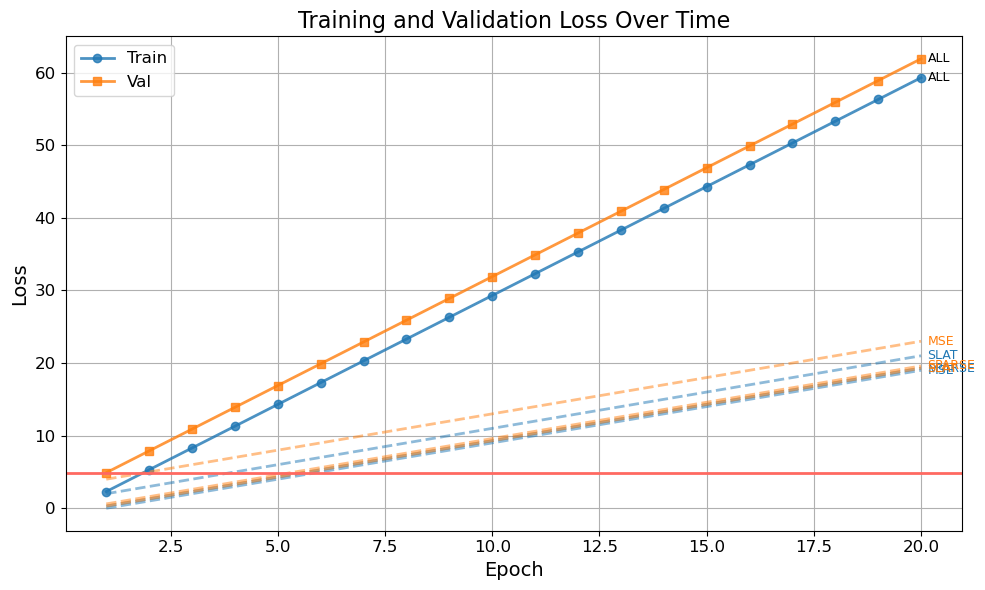

In [104]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, 21)

combined_tr = [sum(values) for values in zip(*[data_tr[key] for key in data_tr.keys()])]
combined_val = [sum(values) for values in zip(*[data_val[key] for key in data_val.keys()])]

bestVal = min(combined_val)

plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(epochs, combined_tr, label="Train", marker='o', linestyle='-', color='#1f77b4', linewidth=2, alpha = 0.8)  # Customize train curve with softer blue color
plt.plot(epochs, combined_val, label="Val", marker='s', linestyle='-', color='#ff7f0e', linewidth=2, alpha = 0.8)
plt.text(epochs[-1] + 0.15, combined_tr[-1], 'ALL', verticalalignment = 'center', fontsize = 9)
plt.text(epochs[-1] + 0.15, combined_val[-1], 'ALL', verticalalignment = 'center', fontsize = 9)

for idx,key in enumerate(list(data_tr.keys())):
    plt.plot(epochs, data_tr[key], linestyle='--', color='#1f77b4', linewidth=2, alpha = 0.5)
    plt.text(epochs[-1] + 0.15, data_tr[key][-1], key, verticalalignment = 'center', fontsize = 9, color = '#1f77b4')

for idx,key in enumerate(list(data_val.keys())):
    plt.plot(epochs, data_val[key], linestyle='--', color='#ff7f0e', linewidth=2, alpha = 0.5)
    plt.text(epochs[-1] + 0.15, data_val[key][-1], key, verticalalignment = 'center', fontsize = 9, color = '#ff7f0e')

plt.axhline(bestVal, linestyle='-', color='#FF6961', linewidth=2, alpha = 1)

plt.title("Training and Validation Loss Over Time", fontsize=16)
plt.xlabel("Epoch", fontsize=14)  
plt.ylabel("Loss", fontsize=14)  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.legend(fontsize=12) 
plt.grid(True)  
plt.tight_layout()  

plt.show()


In [63]:
test = {'A': []}
test[list(test.keys())[0]]

[]

In [45]:
a = [np.array([1,2,3]),np.array([4,5,6]),np.array([7,8,9])]
idxs = [0,1]
[x for idx in idxs for x in [a[idx]]]

[array([1, 2, 3]), array([4, 5, 6])]

In [62]:
import pandas as pd
import numpy as np

# Define the data for the DataFrame
data = {
    'Feature1': np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]),
    'Feature4': np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]),
    'Feature5': np.array([2, 8, 5, 3, 2, 2, 8, 5, 3, 2]),
    'Feature6': np.array([2, 1, 5, 32, 2, 2, 1, 5, 32, 2]),
    'Feature7': np.array([2, 3, 4, 0, 2, 2, 3, 4, 0, 2])
}

# Create the DataFrame
df = pd.DataFrame(data)

print(df)


   Feature1  Feature4  Feature5  Feature6  Feature7
0         1       0.1         2         2         2
1         2       0.2         8         1         3
2         3       0.3         5         5         4
3         4       0.4         3        32         0
4         5       0.5         2         2         2
5         1       0.1         2         2         2
6         2       0.2         8         1         3
7         3       0.3         5         5         4
8         4       0.4         3        32         0
9         5       0.5         2         2         2


In [63]:
list(data.values())

[array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]),
 array([2, 8, 5, 3, 2, 2, 8, 5, 3, 2]),
 array([ 2,  1,  5, 32,  2,  2,  1,  5, 32,  2]),
 array([2, 3, 4, 0, 2, 2, 3, 4, 0, 2])]

[[ -45.93055    28.835352]
 [ 194.68057   109.05402 ]
 [  42.049473 -213.49263 ]
 [-252.57896    28.669697]
 [ 105.68342    -9.885505]]


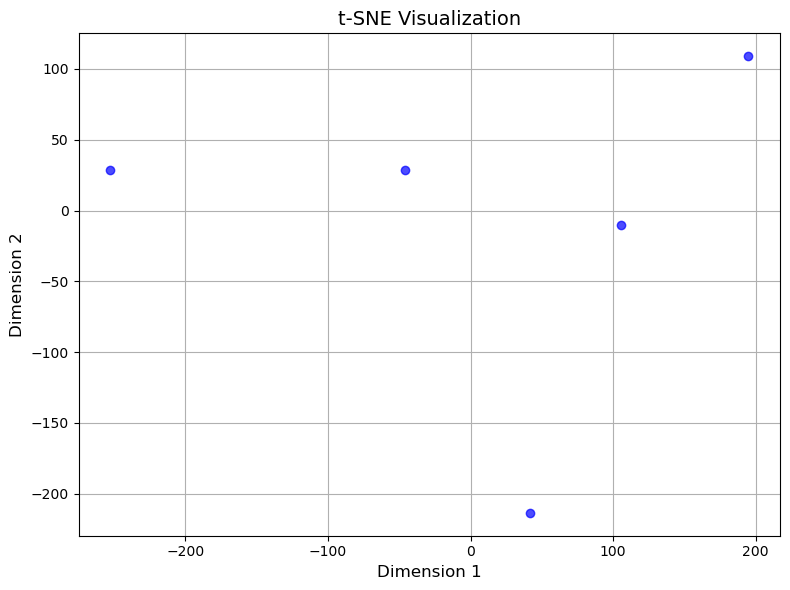

In [64]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vals = np.array(list(data.values()))
x_embedded = TSNE(n_components = 2, perplexity = 2).fit_transform(vals)

print(x_embedded)

plt.figure(figsize=(8, 6))  # Adjust the figure size

plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c='blue', alpha=0.7, label='Data Points')
plt.xlabel('Dimension 1', fontsize=12) 
plt.ylabel('Dimension 2', fontsize=12)
plt.title('t-SNE Visualization', fontsize=14)
#plt.legend(loc='best', fontsize=10) 
plt.grid(True)
plt.tight_layout()
plt.show()


--------------------

### Tests for prediction

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd

from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sksurv.datasets import load_flchain, load_gbsg2
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv


In [27]:
x, y = load_flchain()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [28]:
print(y_train)

[(False, 4331.) (False, 4548.) (False, 2226.) ... ( True, 4266.)
 ( True,  681.) (False, 2477.)]


In [29]:
num_columns = ["age", "creatinine", "kappa", "lambda"]

imputer = SimpleImputer().fit(x_train.loc[:, num_columns])
x_test_imputed = imputer.transform(x_test.loc[:, num_columns])

In [30]:
x_test_imputed

array([[52.        ,  0.9       ,  1.18      ,  1.45      ],
       [53.        ,  0.9       ,  1.45      ,  1.49      ],
       [70.        ,  1.1       ,  1.25      ,  1.72      ],
       ...,
       [72.        ,  1.09548944,  1.02      ,  1.4       ],
       [55.        ,  0.9       ,  0.62      ,  1.15      ],
       [50.        ,  1.1       ,  0.667     ,  1.023     ]])

In [31]:
y_events = y_train[y_train["death"]]
train_min, train_max = y_events["futime"].min(), y_events["futime"].max()

y_events = y_test[y_test["death"]]
test_min, test_max = y_events["futime"].min(), y_events["futime"].max()

assert (
    train_min <= test_min < test_max < train_max
), "time range or test data is not within time range of training data."

In [32]:
times = np.percentile(y["futime"], np.linspace(5, 81, 15))
print(times)

[ 470.3        1259.         1998.         2464.82428571 2979.
 3401.         3787.99857143 4051.         4249.         4410.17285714
 4543.         4631.         4695.         4781.         4844.        ]


In [33]:
x_test_imputed

array([[52.        ,  0.9       ,  1.18      ,  1.45      ],
       [53.        ,  0.9       ,  1.45      ,  1.49      ],
       [70.        ,  1.1       ,  1.25      ,  1.72      ],
       ...,
       [72.        ,  1.09548944,  1.02      ,  1.4       ],
       [55.        ,  0.9       ,  0.62      ,  1.15      ],
       [50.        ,  1.1       ,  0.667     ,  1.023     ]])

(0.7929451629288902, 411434, 104954, 10253, 48)
(0.5845461764179734, 283124, 188014, 55503, 48)
(0.675223253631379, 358994, 165726, 1921, 48)
(0.6686614075117864, 357350, 167141, 2150, 48)


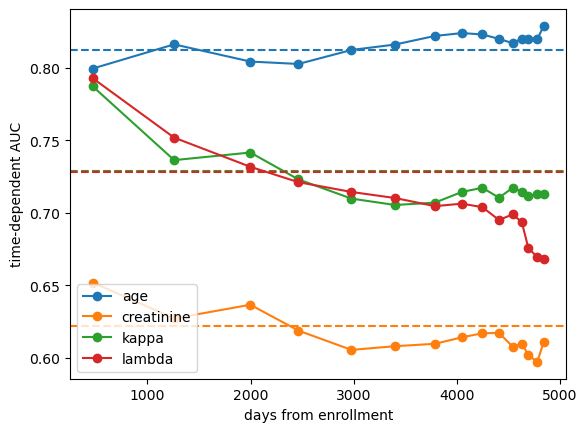

In [34]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()


for i, col in enumerate(num_columns):
    plot_cumulative_dynamic_auc(x_test_imputed[:, i], col, color=f"C{i}")
    ret = concordance_index_ipcw(y_train, y_test, x_test_imputed[:, i], tau=times[-1])
    print(ret)

--------------------------

In [170]:
from sksurv.datasets import load_veterans_lung_cancer

va_x, va_y = load_veterans_lung_cancer()

va_x_train, va_x_test, va_y_train, va_y_test = train_test_split(
    va_x, va_y, test_size=0.2, stratify=va_y["Status"], random_state=0
)

In [171]:
va_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [172]:
va_y_train

array([( True, 103.), ( True,  84.), ( True,  24.), ( True, 553.),
       ( True,  99.), ( True,  21.), ( True,  48.), ( True,  59.),
       ( True, 278.), ( True,  18.), ( True,  15.), ( True, 242.),
       ( True, 287.), ( True,  95.), ( True,  19.), ( True,  30.),
       ( True,  80.), ( True, 999.), ( True,   8.), ( True, 991.),
       ( True, 389.), ( True,  27.), ( True, 467.), (False, 231.),
       ( True,  90.), ( True,  51.), ( True,  10.), ( True,  99.),
       ( True,  52.), ( True,   8.), ( True, 260.), ( True,  18.),
       ( True,  13.), ( True,  52.), ( True,  13.), ( True,   4.),
       (False, 123.), ( True,  61.), ( True, 411.), ( True,  19.),
       ( True,  29.), ( True,  31.), ( True,  31.), ( True, 117.),
       ( True,   7.), ( True,  25.), ( True, 118.), ( True,  54.),
       ( True,  25.), (False,  97.), ( True, 384.), ( True, 357.),
       ( True, 231.), ( True, 143.), ( True,   2.), ( True,   3.),
       ( True,  22.), ( True,   8.), ( True, 139.), ( True, 11

In [175]:
va_y_train[va_y_train['Status'] == False]['Survival_in_days']

array([231., 123.,  97.,  83., 182., 103.,  25.])

In [178]:
va_y_test[va_y_test['Status'] == False]['Survival_in_days']

array([100.,  87.])

In [147]:
import numpy as np

# Create a NumPy array
arr = np.array([[1, 2, 3], [4, 5, 6]])

# Get the shape of the NumPy array
shape = arr.shape

print("Shape of the NumPy array:", np.prod(shape))


Shape of the NumPy array: 6


In [166]:
va_y_train[23]['Survival_in_days'] = 1000
va_y_train

array([( True,  103.), ( True,   84.), ( True,   24.), ( True,  553.),
       ( True,   99.), ( True,   21.), ( True,   48.), ( True,   59.),
       ( True,  278.), ( True,   18.), ( True,   15.), ( True,  242.),
       ( True,  287.), ( True,   95.), ( True,   19.), ( True,   30.),
       ( True,   80.), ( True,  999.), ( True,    8.), ( True,  991.),
       ( True,  389.), ( True,   27.), ( True,  467.), (False, 1000.),
       ( True,   90.), ( True,   51.), ( True,   10.), ( True,   99.),
       ( True,   52.), ( True,    8.), ( True,  260.), ( True,   18.),
       ( True,   13.), ( True,   52.), ( True,   13.), ( True,    4.),
       (False,  123.), ( True,   61.), ( True,  411.), ( True,   19.),
       ( True,   29.), ( True,   31.), ( True,   31.), ( True,  117.),
       ( True,    7.), ( True,   25.), ( True,  118.), ( True,   54.),
       ( True,   25.), (False,   97.), ( True,  384.), ( True,  357.),
       ( True,  231.), ( True,  143.), ( True,    2.), ( True,    3.),
      

In [167]:
cph = make_pipeline(OneHotEncoder(), CoxnetSurvivalAnalysis(l1_ratio=0.95, fit_baseline_model = True))
cph.fit(va_x_train, va_y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(fit_baseline_model=True,
                                        l1_ratio=0.95))])

In [168]:
va_y_test[5]['Survival_in_days'] = 1000
va_y_test

array([( True,  392.), ( True,   11.), ( True,  156.), ( True,  340.),
       ( True,  117.), ( True, 1000.), (False,  100.), ( True,   20.),
       ( True,  111.), ( True,   33.), ( True,    7.), ( True,  162.),
       ( True,    7.), (False,   87.), ( True,  283.), ( True,   45.),
       ( True,   51.), ( True,   42.), ( True,   43.), ( True,   21.),
       ( True,   16.), ( True,   54.), ( True,   15.), ( True,  112.),
       ( True,   12.), ( True,   44.), ( True,  587.), ( True,    1.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [169]:
va_times = np.arange(1, 587, 7)
cph_risk_scores = cph.predict(va_x_test, alpha = 0.01)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(va_y_train, va_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.grid(True)

ValueError: censoring survival function is zero at one or more time points

In [141]:
X = cph.predict_cumulative_hazard_function(va_x_test, alpha = None)
X

array([StepFunction(x=array([   2.,    3.,    4.,    7.,    8.,   10.,   12.,   13.,   15.,
                18.,   19.,   20.,   21.,   22.,   24.,   25.,   27.,   29.,
                30.,   31.,   35.,   36.,   48.,   49.,   51.,   52.,   53.,
                54.,   56.,   59.,   61.,   63.,   72.,   73.,   80.,   82.,
                83.,   84.,   87.,   90.,   92.,   95.,   97.,   99.,  100.,
               103.,  105.,  110.,  111.,  117.,  118.,  122.,  123.,  126.,
               132.,  133.,  139.,  140.,  143.,  144.,  151.,  153.,  162.,
               164.,  177.,  182.,  186.,  200.,  201.,  216.,  228.,  231.,
               242.,  250.,  260.,  278.,  287.,  314.,  357.,  378.,  384.,
               389.,  411.,  467.,  553.,  991.,  999., 1000.]), y=array([6.15378541e-03, 1.23998013e-02, 1.88106318e-02, 2.53145147e-02,
              5.20009959e-02, 6.62045581e-02, 7.34730504e-02, 8.81210421e-02,
              9.57367899e-02, 1.18980813e-01, 1.35863673e-01, 1.44629936e-01

Median:  32.51291724413553  - Mean:  46.85625193512778
Median:  286.9785639146976  - Mean:  400.9621426106544
Median:  132.5211874301285  - Mean:  175.72836560941303
Median:  170.62877675181312  - Mean:  248.83254501407617
Median:  110.24061168869471  - Mean:  141.17878956373383
Median:  68.3865059667216  - Mean:  80.02694877512901
Median:  222.93229071133678  - Mean:  307.7807124047139
Median:  28.742472209119587  - Mean:  39.22128309190626
Median:  93.57038100656312  - Mean:  109.59725642863218
Median:  75.06649791480994  - Mean:  85.27287669674034
Median:  51.33973342788068  - Mean:  59.766069944006595
Median:  91.4824997442107  - Mean:  104.82207172173992
Median:  18.26936421564276  - Mean:  21.68625603098591
Median:  249.2585977386674  - Mean:  353.3051142242417
Median:  359.8053018286297  - Mean:  443.60186415483145
Median:  23.316163637073327  - Mean:  30.293778044426833
Median:  48.5052674813102  - Mean:  52.46559380950023
Median:  157.96378712219035  - Mean:  229.4861202736306

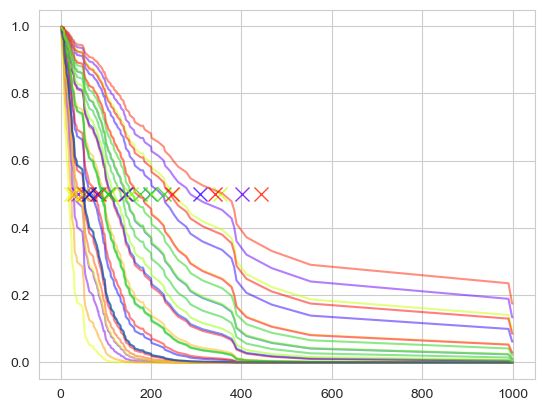

In [138]:
G = cph.predict_survival_function(va_x_test, alpha = None)
predicted_values = []
for g in G:
    color = plt.cm.prism(np.random.rand())  # Random color
    plt.plot(g.x, g.y, color=color, alpha=0.5)

    median_value2 = np.interp(0.5, g.y[::-1], g.x[::-1])
    median_value = np.trapz(g.y, g.x)
    print("Median: ", median_value2, " - Mean: ", median_value)
    predicted_values += [median_value]
    plt.plot(median_value, 0.5, 'x', color=color, alpha=0.8, markersize=10)
plt.show()

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Import Seaborn for improved aesthetics

# Set Seaborn style
sns.set_style("whitegrid")

# Increase figure size
plt.figure(figsize=(12, 10))
# Assuming va_y_test and predicted_values are your data arrays

# AX 0, 0 :: Survival function
G = cph.predict_survival_function(va_x_test, alpha=None)

for idx, g in enumerate(G):
    color = plt.cm.prism(np.random.rand())  # Random color
    plt.subplot(2, 2, 1)
    plt.plot(g.x, g.y, color=color, alpha=0.5)

    median_value = np.interp(0.5, g.y[::-1], g.x[::-1])
    plt.plot(median_value, 0.5, 'x', color=color, alpha=0.8, markersize=10)
    plt.title('Survival Function')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')

# AX 0, 1 :: Box plots
plt.subplot(2, 2, 2)
plt.boxplot([va_y_test['Survival_in_days'], predicted_values], labels=['y', r'$\hat{y}$'])
plt.title('Box Plot')
plt.ylabel('Time')

# AX 1, 0 :: Residuals
residuals = va_y_test['Survival_in_days'] - predicted_values
plt.subplot(2, 2, 3)
sns.histplot(residuals, bins=20, color='skyblue', alpha=0.7, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# AX 1, 1 :: Actual vs predicted
indices = np.arange(len(va_y_test['Survival_in_days']))
bar_width = 0.35
plt.subplot(2, 2, 4)
plt.bar(indices, va_y_test['Survival_in_days'], bar_width, color='red', label='Actual', alpha=0.7)
plt.bar(indices + bar_width + 0.1, predicted_values, bar_width, color='blue', label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Patient')
plt.ylabel('Time')
plt.legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


NameError: name 'cph' is not defined

<Figure size 1200x1000 with 0 Axes>

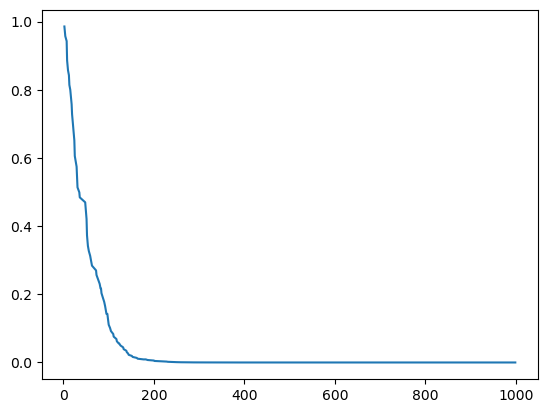

In [27]:
plt.plot(G[0].x, G[0].y)

34.76990354661818


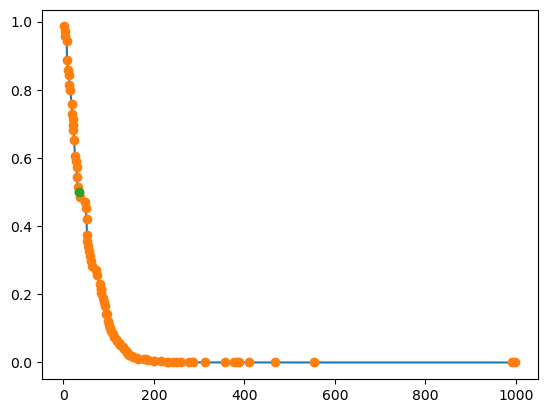

In [63]:
x = G[0].x
y = G[0].y


xnew = np.linspace(min(x), max(x), 1000)
ynew = np.interp(xnew, x, y)
# values have to be reversed as the interpolation expects ascending order
median_value = np.interp(0.5, y[::-1], x[::-1])
print(median_value)

plt.plot(xnew, ynew, '-')
plt.plot(x,y,'o')
plt.plot(median_value, 0.5, 'o')
plt.show()

In [42]:
import scipy.stats as stats

survival_probs = []
for g in G:
    survival_probs += [g.y]
    
survival_probs
lambda_param = np.log(survival_probs[0]) / len(survival_probs[0])
lambda_param

array([-1.63944851e-04, -3.30612254e-04, -5.01905579e-04, -6.75814705e-04,
       -1.39006337e-03, -1.77108017e-03, -1.96634044e-03, -2.35994706e-03,
       -2.56500174e-03, -3.19157141e-03, -3.64989508e-03, -3.88902404e-03,
       -4.13539900e-03, -4.39631815e-03, -4.92418263e-03, -5.76181339e-03,
       -6.06464293e-03, -6.37157157e-03, -7.00780865e-03, -7.65568032e-03,
       -7.98649935e-03, -8.33035457e-03, -8.68067696e-03, -9.09086276e-03,
       -9.94245177e-03, -1.13347646e-02, -1.18307693e-02, -1.23347594e-02,
       -1.28434308e-02, -1.33569626e-02, -1.39049574e-02, -1.44653795e-02,
       -1.50462370e-02, -1.56316900e-02, -1.68563091e-02, -1.75698846e-02,
       -1.75698846e-02, -1.83055384e-02, -1.90585567e-02, -1.98455264e-02,
       -2.06743949e-02, -2.23906507e-02, -2.23906507e-02, -2.42922666e-02,
       -2.53055273e-02, -2.63402331e-02, -2.74280775e-02, -2.85306172e-02,
       -2.96417516e-02, -3.07685467e-02, -3.19335082e-02, -3.31094226e-02,
       -3.31094226e-02, -

In [43]:
stats.expon.fit(lambda_param)

(-0.4764751124946809, 0.43010844352391164)

-------------------------

In [52]:
import torch
import math

from typing import List

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, GridSearchCV
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_concordance_index_ipcw_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

In [32]:
va_x_train = va_x_train[['Age_in_years','Karnofsky_score']]
va_x_test = va_x_test[['Age_in_years','Karnofsky_score']]
cv = KFold(n_splits=5, shuffle = True, random_state = 46)
gcv = GridSearchCV(
            as_concordance_index_ipcw_scorer(CoxnetSurvivalAnalysis(l1_ratio=0.95, fit_baseline_model = True)),
            param_grid = {"estimator__alphas": [[v] for v in [0.001, 0.01]]},
            cv = cv,
            error_score = 0,
            n_jobs = 4,
).fit(va_x_train, va_y_train)

In [33]:
va_x_test

,Age_in_years,Karnofsky_score
43,68.0,40.0
14,48.0,70.0
62,66.0,70.0
131,64.0,80.0
24,46.0,80.0
76,65.0,20.0
9,70.0,70.0
95,54.0,30.0
133,64.0,60.0
79,64.0,30.0


In [37]:
va_x_test.values

array([[68., 40.],
       [48., 70.],
       [66., 70.],
       [64., 80.],
       [46., 80.],
       [65., 20.],
       [70., 70.],
       [54., 30.],
       [64., 60.],
       [64., 30.],
       [72., 50.],
       [64., 80.],
       [66., 20.],
       [48., 80.],
       [51., 90.],
       [69., 40.],
       [62., 60.],
       [81., 60.],
       [49., 60.],
       [55., 40.],
       [53., 30.],
       [67., 70.],
       [40., 50.],
       [60., 80.],
       [63., 50.],
       [70., 60.],
       [58., 60.],
       [35., 50.]])

In [35]:
best_model = gcv.best_estimator_.estimator
best_model.predict_survival_function(va_x_test.values, alpha = 0.001)

C:\Users\inigo\anaconda3\envs\P10\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but CoxnetSurvivalAnalysis was fitted with feature names
  warnings.warn(


array([StepFunction(x=array([  2.,   3.,   4.,   7.,   8.,  10.,  12.,  13.,  15.,  18.,  19.,
               20.,  21.,  22.,  24.,  25.,  27.,  29.,  30.,  31.,  35.,  36.,
               48.,  49.,  51.,  52.,  53.,  54.,  56.,  59.,  61.,  63.,  72.,
               73.,  80.,  82.,  83.,  84.,  87.,  90.,  92.,  95.,  97.,  99.,
              100., 103., 105., 110., 111., 117., 118., 122., 123., 126., 132.,
              133., 139., 140., 143., 144., 151., 153., 162., 164., 177., 182.,
              186., 200., 201., 216., 228., 231., 242., 250., 260., 278., 287.,
              314., 357., 378., 384., 389., 411., 467., 553., 991., 999.]), y=array([9.85665975e-01, 9.71355043e-01, 9.56990456e-01, 9.42657991e-01,
              8.86662215e-01, 8.58270892e-01, 8.43756355e-01, 8.14976974e-01,
              8.00497856e-01, 7.57549652e-01, 7.28000603e-01, 7.13118717e-01,
              6.98112765e-01, 6.82764606e-01, 6.52748128e-01, 6.08828690e-01,
              5.93456015e-01, 5.78286244e-

In [104]:
a,b = train_test_split(va_x_train, test_size = 0.2)
a

,Age_in_years,Karnofsky_score
114,70.0,60.0
112,50.0,60.0
93,60.0,60.0
13,52.0,80.0
20,55.0,40.0
...,...,...
72,52.0,50.0
27,68.0,60.0
80,63.0,20.0
119,63.0,70.0


---------------

In [106]:
from sklearn.metrics import mean_squared_error

current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Implementation', 'Logic', 'predictions_test.csv'))

# expression data
tabular_data = pd.read_csv(somepath, sep = ',', index_col = 0)
mse = mean_squared_error(tabular_data['PFS'], tabular_data['predicted_PFS'])
mse

37.477096963325

In [107]:
tabular_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP,WNT16,PFS,CENSOR,predicted_PFS
id,,,,,,,,,,,,,,,,,,,,,
X1cb9577d90b2a15e59959f7f911e6689,0.377963,0.297245,0.229340,0.401025,0.299808,0.480461,0.318386,0.506086,0.388213,0.365791,...,0.435618,0.360666,0.182575,0.435618,0.438181,0.552851,0.000641,15.211499,0.0,5.536345
X7c31805a23583362dc8ada543ae0bd69,0.396541,0.297886,0.246637,0.383728,0.321589,0.509930,0.338885,0.475336,0.411275,0.354260,...,0.411275,0.354901,0.233824,0.358744,0.375400,0.328636,0.000641,5.782341,0.0,8.317438
X188bc1d97d61f0caececb8fe2eeed462,0.377963,0.302370,0.187060,0.397181,0.348495,0.536835,0.333760,0.445227,0.413837,0.359385,...,0.372197,0.317104,0.250480,0.397822,0.424728,0.303011,0.000641,20.731007,0.0,9.709190
Xfa8012d58e6e95476342cc3e0d7eefa3,0.335042,0.304933,0.130685,0.384369,0.372197,0.503523,0.278668,0.454196,0.333120,0.333760,...,0.400384,0.354260,0.196669,0.436259,0.454837,0.336964,0.000641,1.774127,0.0,9.904053
X70d85275acf86d8a3299e613e53a4181,0.387572,0.262012,0.181935,0.361947,0.274824,0.446509,0.316464,0.546445,0.436899,0.374119,...,0.421525,0.411915,0.247918,0.438821,0.444587,0.566304,0.000641,3.252567,0.0,23.622177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X897660095e14291476c04c07d62ab19c,0.404228,0.290199,0.176169,0.398463,0.319026,0.477899,0.343370,0.529789,0.493914,0.366432,...,0.385010,0.283152,0.301089,0.440103,0.462524,0.433696,0.000641,12.583162,1.0,9.551370
Xbdfa6222382f82a7f9b125c93057cc7b,0.386291,0.310058,0.224215,0.411275,0.315823,0.478539,0.310058,0.497117,0.432415,0.366432,...,0.424728,0.421525,0.264574,0.449071,0.425368,0.597694,0.000641,5.552361,1.0,5.576590
Xceed74a24dea8bbb00de34feee199cdc,0.357463,0.248559,0.217809,0.360026,0.237028,0.439462,0.269058,0.548366,0.461883,0.393978,...,0.487508,0.429853,0.308136,0.418322,0.429212,0.361947,0.000641,10.250513,1.0,9.600346


In [1]:
import torch
torch.cuda.is_available()

True

In [5]:
import pandas as pd

# Example DataFrames
data = {'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]}
df = pd.DataFrame(data)

additional_features_data = {'D': [10, 11, 12], 'E': [13, 14, 15]}
additional_df = pd.DataFrame(additional_features_data)

# Divide each column by its maximal value
df_max_normalized = df / df.max()

# Merge the two DataFrames
merged_df = pd.concat([df_max_normalized, additional_df], axis=1)

print(merged_df)


          A         B         C   D   E
0  0.333333  0.666667  0.777778  10  13
1  0.666667  0.833333  0.888889  11  14
2  1.000000  1.000000  1.000000  12  15


In [7]:
import numpy as np

# Example arrays
A = np.random.rand(100, 3000)  # Example of size 100x3000
B = list(np.random.rand(100, 5))      # Example of size 100x5

# Concatenate arrays along the second axis (columns)
result = np.concatenate((A, B), axis=1)

# Print the shape of the result array
print(result.shape)


(100, 3005)


C:\Users\inigo\anaconda3\envs\P10\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\inigo\anaconda3\envs\P10\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[ 1.20048936  0.23390308]
 [-0.69308021  0.82220081]
 [-0.38529354 -0.93196658]]


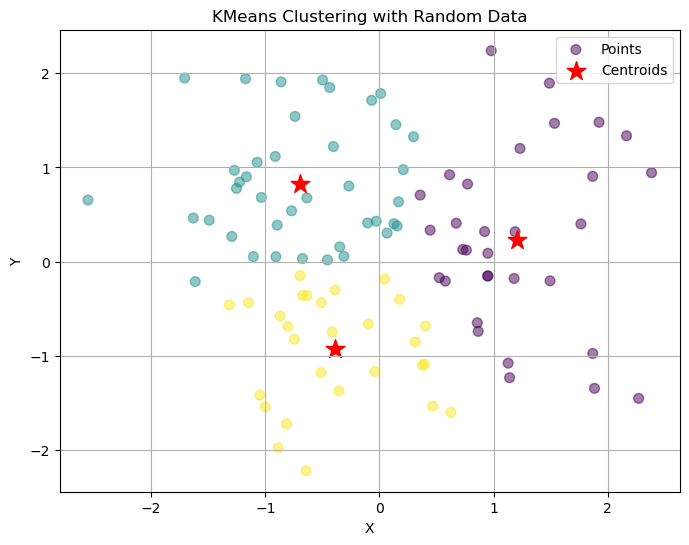

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generating random data
np.random.seed(0)
X = np.random.randn(100, 2)  # 100 points in 2-dimensional space

# Applying KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)  # Assuming 3 clusters
kmeans.fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Plotting the points and centroids
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5, label='Points')

centroids_manual = []
for label in np.unique(labels):
    cluster_points = X[labels == label]
    centroid = np.mean(cluster_points, axis=0)
    centroids_manual.append(centroid)
centroids_manual = np.array(centroids_manual)

print(centroids_manual)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='red', s=200, label='Centroids')
plt.title('KMeans Clustering with Random Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Example data and labels
data = torch.randn(100, 3)  # Example data with shape (100, 3)
labels = torch.randint(0, 2, (100,))  # Example labels (binary classification)

# Create custom dataset object
custom_dataset = CustomDataset(data, labels)

# Create DataLoader
batch_size = 32
shuffle = True
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle)

# Example usage of DataLoader in training loop
for batch_data, batch_labels in data_loader:
    # Perform training iteration using batch_data and batch_labels
    pass


In [26]:
custom_dataset.data

tensor([[ 1.1800e+00, -1.4359e+00, -2.9911e-01],
        [-1.5519e-01,  1.0504e+00,  4.7648e-01],
        [-4.2237e-01,  1.2835e+00,  8.9305e-01],
        [-1.7236e+00,  3.2835e-01,  1.0135e+00],
        [ 4.1143e-01, -1.0018e+00, -4.2715e-01],
        [-2.0036e+00,  4.2303e-01,  7.8080e-01],
        [-1.1939e-01, -2.9649e-01, -3.5992e-01],
        [-1.2423e+00,  6.6226e-01,  7.2447e-01],
        [ 1.4682e+00, -1.8496e+00,  8.8483e-01],
        [ 8.8432e-01, -1.5158e+00,  1.0982e+00],
        [ 1.0864e-01,  3.0777e-01, -5.1754e-01],
        [ 2.8973e+00,  3.4900e-01, -4.5931e-01],
        [-4.5196e-01,  8.8577e-01,  7.1087e-01],
        [ 1.4122e+00, -4.4285e-02, -4.0738e-01],
        [ 1.1454e+00, -1.3184e+00,  4.7159e-01],
        [-9.5465e-01,  5.8939e-02, -1.8404e+00],
        [-4.7033e-03,  9.1573e-01, -1.6306e+00],
        [ 9.7746e-01,  6.3317e-01, -2.3183e-01],
        [ 8.3802e-01, -4.8599e-01,  3.1770e-01],
        [ 9.5648e-04, -6.6949e-01,  3.0111e-01],
        [-3.4593e-01

In [41]:
import numpy as np
import torch

# Create a NumPy array of random numbers
numpy_array = np.random.randn(8, 3, 10, 100)

# Convert the NumPy array to a PyTorch tensor
torch_tensor = torch.tensor(numpy_array)

# Output the shape of the PyTorch tensor
print("Shape of the PyTorch tensor:", torch_tensor.shape)


Shape of the PyTorch tensor: torch.Size([8, 3, 10, 100])


In [62]:
X = np.array(list(torch_tensor)[:,0,:,:].detach().tolist())
X.shape

TypeError: list indices must be integers or slices, not tuple

In [79]:
import torch
import numpy as np

# Assuming loader is a list containing PyTorch tensors
# Example loader
numpy_array = np.random.randn(8, 3, 10, 100).tolist()

# Convert the NumPy array to a PyTorch tensor
loader = (numpy_array)


# Example dim
dim = 1

loader_lists = [tensor for tensor in loader]
    
# Extract slices along the specified dimension
slices = [tensor[dim] for tensor in loader_lists]
    
# Flatten the slices
flattened_slices = [item for sublist in slices for item in sublist]
    
len(flattened_slices[0])


100

In [82]:
import torch

# Example list of tensors
tensor_list = [torch.tensor([0.3983, 0.2701, 0.2299, 0.4294, 0.4437, 0.3802]),
               torch.tensor([0.4165, 0.3232, 0.1788, 0.4514, 0.4262, 0.5304])]

len0 = len(tensor_list)
len1 = len(tensor_list[0])

# Stack the tensors along a new dimension
stacked_tensor = torch.stack(tensor_list)

# Reshape the stacked tensor to shape 2x6
reshaped_tensor = stacked_tensor.reshape(len0, len1)

print(reshaped_tensor)


tensor([[0.3983, 0.2701, 0.2299, 0.4294, 0.4437, 0.3802],
        [0.4165, 0.3232, 0.1788, 0.4514, 0.4262, 0.5304]])


In [31]:
from torch_geometric.datasets import PPI
from torch_geometric.data import Data, DataLoader

dataset = PPI("PPI_Delete")


Extracting PPI_Delete\ppi.zip
Processing...
Done!


In [32]:
for i in dataset:
    print(i)

Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Data(x=[1377, 50], edge_index=[2, 29704], y=[1377, 121])
Data(x=[2263, 50], edge_index=[2, 59644], y=[2263, 121])
Data(x=[2339, 50], edge_index=[2, 65430], y=[2339, 121])
Data(x=[1578, 50], edge_index=[2, 36162], y=[1578, 121])
Data(x=[1021, 50], edge_index=[2, 18216], y=[1021, 121])
Data(x=[1823, 50], edge_index=[2, 44330], y=[1823, 121])
Data(x=[2488, 50], edge_index=[2, 70390], y=[2488, 121])
Data(x=[591, 50], edge_index=[2, 7708], y=[591, 121])
Data(x=[3312, 50], edge_index=[2, 106198], y=[3312, 121])
Data(x=[2401, 50], edge_index=[2, 64218], y=[2401, 121])
Data(x=[1878, 50], edge_index=[2, 46268], y=[1878, 121])
Data(x=[1819, 50], edge_index=[2, 45768], y=[1819, 121])
Data(x=[3480, 50], edge_index=[2, 106754], y=[3480, 121])
Data(x=[2794, 50], edge_index=[2, 85318], y=[2794, 121])
Data(x=[2326, 50], edge_index=[2, 59862], y=[2326, 121])
Data(x=[2650, 50], edge_index=[2, 77064], y=[2650, 121])
Data(x=[2815, 50], edge_index=[2

In [33]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=False)

# Step 4: Iterate through the DataLoader and check the output
for i,batch in enumerate(data_loader):
    print(i, batch)
    print(batch.x)

0 DataBatch(x=[7746, 50], edge_index=[2, 187096], y=[7746, 121], batch=[7746], ptr=[5])
tensor([[-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        ...,
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481]])
1 DataBatch(x=[6910, 50], edge_index=[2, 169098], y=[6910, 121], batch=[6910], ptr=[5])
tensor([[-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        ...,
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, -0.1128,  ..., -0.1399, -0.1494, -0.1481],
        [-0.0855, -0.0884, 

C:\Users\inigo\anaconda3\envs\P10\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [34]:
A = list(data_loader)
A[0].x.shape[1]

50

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import GAE
class GNNModel(nn.Module):
    def __init__(self, num_features):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, num_features)
        self.conv2 = GCNConv(num_features, num_features)
        self.pool1 = TopKPooling(2000, ratio = 0.5)
        self.pool2 = TopKPooling(1000, ratio = 0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Apply the first convolutional layer
        x = F.sigmoid(self.conv1(x, edge_index))
        # Perform graph pooling
        x, edge_index, _,_,_,_ = self.pool1(x, edge_index)
        
        # Apply the second convolutional layer
        x = F.sigmoid(self.conv2(x, edge_index))
        # Perform graph pooling
        x, edge_index, _,_,_,_ = self.pool2(x, edge_index)
        return x, edge_index

    def get_latent_space(self, data):
        x, edge_index = data.x, data.edge_index
        encoded = self.encoded(x, edge_index)
        return encoded


class InnerProductDecoder(nn.Module):
    """Decoder for using inner product for prediction."""

    def __init__(self, dropout, act=torch.sigmoid):
        super(InnerProductDecoder, self).__init__()
        self.dropout = dropout
        self.act = nn.ReLU()

    def forward(self, z):
        z = F.dropout(z, self.dropout, training=self.training)
        adj = self.act(torch.mm(z, z.t()))
        print(adj)
        return adj

In [36]:
num_features = 1
model = GNNModel(num_features)

loss = []
criterion = nn.MSELoss(reduction = 'sum')
for idx, b in enumerate(data_loader):
    print(b)
    z = model(b)
    print(len(z))
    loss += [criterion(z, b.x)]
    print("Info about z:")
    print(z)
    print(z.shape)
    # From docs: given latent variables z, computes the binary cross entropy loss for positive edges (b.edge_index)
    output = model.decode(z, b.edge_index)
    print("Info about output:")
    print(idx, output.shape)
    print(output)

print(loss)

NameError: name 'TopKPooling' is not defined

In [95]:
import numpy as np
import torch

# Arbitrary numpy array
numpy_array = np.array([[1, 2, 3], [4, 5, 6]])

# Arbitrary PyTorch tensor
torch_tensor = torch.tensor([[7, 8, 9], [10, 11, 12]])



# Printing the numpy array and tensor
print("Numpy array:")
print(numpy_array)

print("\nPyTorch tensor:")
print(torch_tensor)

np.concatenate((numpy_array, torch_array), axis = 0)


Numpy array:
[[1 2 3]
 [4 5 6]]

PyTorch tensor:
tensor([[ 7,  8,  9],
        [10, 11, 12]])


array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]], dtype=int64)

In [94]:
import numpy as np
import torch

# Arbitrary numpy array
numpy_array = np.array([[1, 2, 3], [4, 5, 6]])

# Arbitrary PyTorch tensor
torch_tensor = torch.tensor([[7, 8, 9], [10, 11, 12]])

# Convert PyTorch tensor to numpy array
torch_array = torch_tensor.numpy()

# Concatenate numpy array and numpy version of PyTorch tensor
concatenated = np.concatenate((numpy_array, torch_array), axis=0)

# Print the concatenated array
print("Concatenated array:")
print(concatenated)


Concatenated array:
[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


In [53]:
import torch

# Latent space tensor
latent_space = torch.tensor([[0.5897915, 0.63272065, 0.9122569, 0.713631, 0.56701386, 0.5346132]])

# Clinical variables list of tensors
clinical_vars_list = [
    torch.tensor([[0.1686, 0.6842, 0.0800, 0.0225, 0.0265],
                 [0.1686, 0.6842, 0.0800, 0.0225, 0.0265]])
    # Add more tensors as needed
]

# Convert the list of tensors to a single tensor
clinical_vars = torch.cat(clinical_vars_list, dim=0)

# Concatenate latent space tensor with clinical vars along dimension 1
combined_tensor = torch.cat((latent_space, clinical_vars), dim=1)

# Print the combined tensor
print("Combined tensor:")
print(combined_tensor)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 2 for tensor number 1 in the list.

In [147]:
import torch
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define the edges of the graph (arbitrary example)
edges = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 0]])

# Define the features for each node (arbitrary example)
x = torch.tensor([[0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5]], dtype=torch.float)

# Define the target labels for each node (arbitrary example)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edges.t().contiguous(), y=y)

print(data)

# Define the number of input and output features
num_features = 2  # Number of input features
num_classes = 4             # Number of output classes

# Apply the GCNConv layer
conv = GCNConv(num_features, num_features)

# Perform one convolution
x = conv(data.x, data.edge_index)

# Print the output after convolution
print("Output after convolution:")
print(x)


Data(x=[4, 2], edge_index=[2, 4], y=[4])
Output after convolution:
tensor([[-0.0681,  0.3550],
        [-0.0421,  0.2242],
        [-0.0681,  0.3550],
        [-0.0940,  0.4859]], grad_fn=<AddBackward0>)


In [3]:
data = np.random.randn(2, 2, 2)
data

array([[[-0.73073467, -0.70533463],
        [ 1.64788966,  0.32445581]],

       [[ 0.0581359 ,  0.69458254],
        [ 0.8681877 , -0.58701418]]])

In [4]:
data[0][0][0] = np.nan
data[0][0][1] = np.nan
data

array([[[        nan,         nan],
        [ 1.64788966,  0.32445581]],

       [[ 0.0581359 ,  0.69458254],
        [ 0.8681877 , -0.58701418]]])

In [5]:
arr = np.array([1, 2, np.nan, 4, np.nan, 6])
arr[~np.isnan(arr)]

array([1., 2., 4., 6.])

In [16]:
import xlsxwriter

workbook = xlsxwriter.Workbook('Test.xlsx')
worksheet = workbook.add_worksheet()

bold_format = workbook.add_format({'bold': True, 'bg_color': '#DDDDDD'})

row = 0
col = 0

cohorts = ['Cohort A', 'Cohort B']
names = ['Type A', 'Type B']
NUM_FOLDS = len(data[0][0])


worksheet.write(row, col, 'Cohort', bold_format)
col += 1
worksheet.write(row, col, 'Type', bold_format)
col += 1
for c_f in range(NUM_FOLDS):
    worksheet.write(row, col, 'Fold ' + str(c_f), bold_format)
    col += 1
row += 1
col = 0

for c_idx, cohort in enumerate(data):
    worksheet.write(row, col, cohorts[c_idx], bold_format)
    col += 1
    for i, foldX in enumerate(cohort):
        worksheet.write(row, col, names[i])
        for x in foldX:
            col += 1
            strToInsert = x
            if np.isnan(x):
                strToInsert = "-"
            worksheet.write(row, col, strToInsert)
        col = 1
        row += 1
    col = 0

workbook.close()

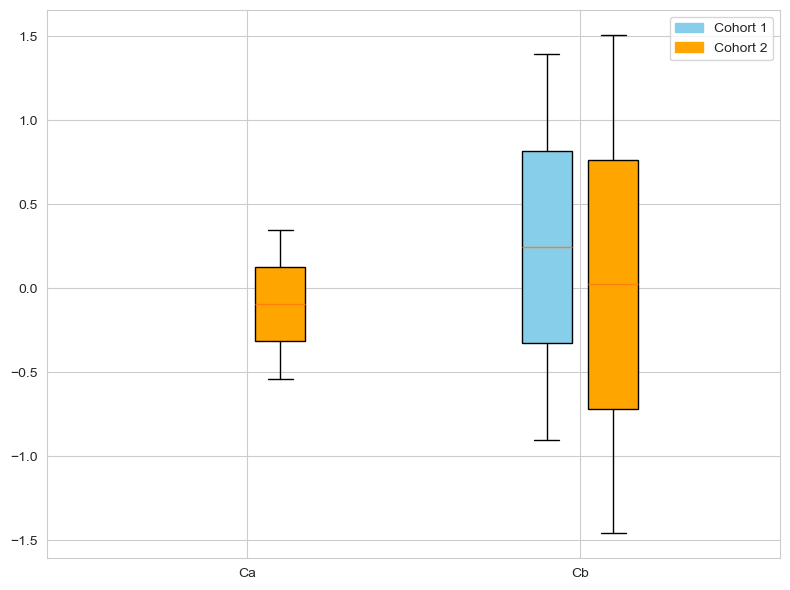

In [65]:
import matplotlib.patches as mpatches

colors = ['skyblue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(8, 6))  # Adjust figure size

for c_idx, cohort in enumerate(data):
    off = 0.1
    if c_idx == 0:
        off = -off
    for i, x in enumerate(cohort):
        plt.boxplot(x[~np.isnan(x)], positions=[i + off], patch_artist=True, boxprops=dict(facecolor=colors[c_idx]))

# Custom legend patches
legend_patches = [mpatches.Patch(color=colors[i], label=f'Cohort {i+1}') for i in range(len(data))]

# Add custom legend
plt.legend(handles=legend_patches, loc='upper right')  # Adjust legend location

plt.xticks(np.arange(len(data)),['Ca','Cb'])

plt.tight_layout()  # Adjust layout to prevent overlapping elements

plt.show()

In [101]:
import numpy as np

# Example data
ys = [[3.6, 5, 4.2], [np.nan, 4, 5], [2, np.nan, 6]]  # Example list of lists with NaN values
means = [np.mean(y) for y in ys]
means

[4.266666666666667, nan, nan]

In [106]:
arr = np.array([np.nan, 4, 5])
np.mean(arr[~np.isnan(arr)])

4.5

In [211]:
import torch
import torch.nn.functional as F
from torch import nn

from enum import Enum

class LossType(Enum):
    MSE = 1
    SPARSE_L1 = 2
    SPARSE_KL = 3
    DENOISING = 4
    VARIATIONAL = 5

    def __str__(self):
        return str(self.name)


In [217]:
A = [[LossType.MSE], [LossType.SPARSE_KL], [LossType.MSE, LossType.SPARSE_KL]]
[[str(x) for x in y] for y in A]

[['MSE'], ['SPARSE_KL'], ['MSE', 'SPARSE_KL']]

In [40]:
COHORTS = ['A', 'B']
foldObjects = {'A': [[1,2,3],[10,20,30]], 'B': [[4,5,6],[40,50,60]]}
combs = 2

[[fold for fold in foldObjects[cohort]] for cohort in COHORTS]

[[[1, 2, 3], [10, 20, 30]], [[4, 5, 6], [40, 50, 60]]]

-------------------------

In [18]:
current_directory = os.getcwd()

somepath = os.path.abspath(
    os.path.join(current_directory, '..', 'Data', 'RNA_dataset_tabular_R3.csv'))

# expression data
tabular_data = pd.read_csv(somepath, sep = ',', index_col = 0)
gene_data = tabular_data
gene_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,CD276,TIPARP,PFS_P,PFS_P_CNSR,MATH,HE_TUMOR_CELL_CONTENT_IN_TUMOR_AREA,PD-L1_TOTAL_IMMUNE_CELLS_PER_TUMOR_AREA,CD8_POSITIVE_CELLS_TUMOR_CENTER,CD8_POSITIVE_CELLS_TOTAL_AREA,TRT01P
id,,,,,,,,,,,,,,,,,,,,,
X00936b9285d6b8665ae9122993fb8e91,6.10,4.38,3.07,6.14,4.70,7.52,4.93,8.37,6.21,5.69,...,7.09,4.94,4.172485,0,17.928391,70.0,0.0,0.08,0.1931,Avelumab+Axitinib
X105622fadc33f23755ac2df823110aca,5.07,3.33,1.73,5.11,5.62,6.58,4.34,7.42,6.15,4.86,...,6.56,4.61,16.591376,1,16.122090,85.0,1.0,0.12,0.1214,Sunitinib
Xe44f39747a8e84b02b4cb24659312144,6.13,4.41,3.23,6.32,5.57,8.02,5.14,7.55,6.87,6.27,...,7.14,8.42,11.104723,0,23.616637,80.0,5.0,0.92,0.9203,Sunitinib
X293dd1284496215e9a0eca9f17a98e7e,5.82,4.30,3.44,6.45,4.86,7.45,4.90,8.39,6.83,5.70,...,6.73,6.28,14.028747,1,24.817435,60.0,5.0,3.16,3.1635,Sunitinib
X01ed7190ce00862696edbf047b542045,6.15,4.21,3.90,5.93,4.43,7.60,4.74,8.31,6.38,5.94,...,6.66,4.93,12.418891,0,19.303863,80.0,2.0,1.98,2.0708,Sunitinib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xc3d410d70dd7359baa40126494fb6765,6.25,3.62,4.80,4.72,5.39,7.01,4.57,6.96,6.26,5.70,...,6.58,6.59,9.790554,1,24.552611,75.0,0.0,1.01,1.0089,Sunitinib
X50772aa64efb859960b20f8801cd6f58,6.27,3.78,3.98,5.95,4.66,7.18,4.61,8.04,6.62,5.80,...,6.74,5.48,4.271047,0,15.672304,75.0,1.0,1.10,1.1775,Sunitinib
X91bcd3067a1a7954692d836515e04869,6.12,3.94,3.25,6.09,4.98,7.32,5.02,8.21,6.71,5.89,...,7.59,7.59,2.496920,0,27.837848,50.0,1.0,4.03,3.9642,Sunitinib


In [19]:
gene_data.drop(gene_data.columns[-8:], axis=1, inplace=True)
gene_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,SLC22A3,SPAG16,HTATIP2,SLC17A1,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP
id,,,,,,,,,,,,,,,,,,,,,
X00936b9285d6b8665ae9122993fb8e91,6.10,4.38,3.07,6.14,4.70,7.52,4.93,8.37,6.21,5.69,...,2.53,4.35,4.45,4.47,7.07,5.23,4.08,8.68,7.09,4.94
X105622fadc33f23755ac2df823110aca,5.07,3.33,1.73,5.11,5.62,6.58,4.34,7.42,6.15,4.86,...,5.74,4.44,4.76,4.45,7.40,6.84,2.84,6.08,6.56,4.61
Xe44f39747a8e84b02b4cb24659312144,6.13,4.41,3.23,6.32,5.57,8.02,5.14,7.55,6.87,6.27,...,4.64,4.08,4.63,2.94,6.66,5.81,4.16,6.33,7.14,8.42
X293dd1284496215e9a0eca9f17a98e7e,5.82,4.30,3.44,6.45,4.86,7.45,4.90,8.39,6.83,5.70,...,4.52,4.74,4.92,0.83,6.67,5.27,4.12,6.97,6.73,6.28
X01ed7190ce00862696edbf047b542045,6.15,4.21,3.90,5.93,4.43,7.60,4.74,8.31,6.38,5.94,...,1.97,5.37,5.58,6.70,6.53,5.84,4.35,5.67,6.66,4.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xc3d410d70dd7359baa40126494fb6765,6.25,3.62,4.80,4.72,5.39,7.01,4.57,6.96,6.26,5.70,...,5.72,7.07,4.74,6.92,5.67,7.55,2.32,2.40,6.58,6.59
X50772aa64efb859960b20f8801cd6f58,6.27,3.78,3.98,5.95,4.66,7.18,4.61,8.04,6.62,5.80,...,4.83,5.75,5.57,7.81,7.26,6.15,3.52,5.92,6.74,5.48
X91bcd3067a1a7954692d836515e04869,6.12,3.94,3.25,6.09,4.98,7.32,5.02,8.21,6.71,5.89,...,3.08,4.84,5.23,0.01,6.38,5.20,4.05,7.84,7.59,7.59


In [22]:
gene_data = gene_data / max(gene_data.max())
gene_data

,NFKB1,TNIP2,AMOT,VASP,SS18L1,SMARCA4,SMURF1,HSPA5,SKIL,UBE2I,...,SLC22A3,SPAG16,HTATIP2,SLC17A1,MGST2,CHPT1,STK17A,SULF2,CD276,TIPARP
id,,,,,,,,,,,,,,,,,,,,,
X00936b9285d6b8665ae9122993fb8e91,0.395078,0.283679,0.198834,0.397668,0.304404,0.487047,0.319301,0.542098,0.402202,0.368523,...,0.163860,0.281736,0.288212,0.289508,0.457902,0.338731,0.264249,0.562176,0.459197,0.319948
X105622fadc33f23755ac2df823110aca,0.328368,0.215674,0.112047,0.330959,0.363990,0.426166,0.281088,0.480570,0.398316,0.314767,...,0.371762,0.287565,0.308290,0.288212,0.479275,0.443005,0.183938,0.393782,0.424870,0.298575
Xe44f39747a8e84b02b4cb24659312144,0.397021,0.285622,0.209197,0.409326,0.360751,0.519430,0.332902,0.488990,0.444948,0.406088,...,0.300518,0.264249,0.299870,0.190415,0.431347,0.376295,0.269430,0.409974,0.462435,0.545337
X293dd1284496215e9a0eca9f17a98e7e,0.376943,0.278497,0.222798,0.417746,0.314767,0.482513,0.317358,0.543394,0.442358,0.369171,...,0.292746,0.306995,0.318653,0.053756,0.431995,0.341321,0.266839,0.451425,0.435881,0.406736
X01ed7190ce00862696edbf047b542045,0.398316,0.272668,0.252591,0.384067,0.286917,0.492228,0.306995,0.538212,0.413212,0.384715,...,0.127591,0.347798,0.361399,0.433938,0.422927,0.378238,0.281736,0.367228,0.431347,0.319301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xc3d410d70dd7359baa40126494fb6765,0.404793,0.234456,0.310881,0.305699,0.349093,0.454016,0.295984,0.450777,0.405440,0.369171,...,0.370466,0.457902,0.306995,0.448187,0.367228,0.488990,0.150259,0.155440,0.426166,0.426813
X50772aa64efb859960b20f8801cd6f58,0.406088,0.244819,0.257772,0.385363,0.301813,0.465026,0.298575,0.520725,0.428756,0.375648,...,0.312824,0.372409,0.360751,0.505829,0.470207,0.398316,0.227979,0.383420,0.436528,0.354922
X91bcd3067a1a7954692d836515e04869,0.396373,0.255181,0.210492,0.394430,0.322539,0.474093,0.325130,0.531736,0.434585,0.381477,...,0.199482,0.313472,0.338731,0.000648,0.413212,0.336788,0.262306,0.507772,0.491580,0.491580


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Sigmoid activation for reconstruction
        )

    def forward(self, x):
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded

# Generate synthetic data
def generate_data(num_samples, input_dim):
    data = np.random.rand(num_samples, input_dim)
    return torch.tensor(data, dtype=torch.float32)

# Hyperparameters
input_dim = 10000  # Dimensionality of input data
encoding_dim = 32  # Dimensionality of encoded representation
num_samples = 1000  # Number of synthetic data samples

# Instantiate the autoencoder model
model = Autoencoder(input_dim, encoding_dim)

# Generate synthetic data
data = generate_data(num_samples, input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
RHO = 0.01
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    output = model(data)
    # Compute the loss
    loss = criterion(output, data)
    print("Reconstruction loss: ", loss)
    print("KL loss: ", kl_loss(RHO, list(model.parameters())))

    loss += kl_loss(RHO, list(model.parameters()))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Reconstruction loss:  tensor(0.0836, grad_fn=<MseLossBackward0>)
KL loss:  tensor(413.8596, grad_fn=<AddBackward0>)
Epoch [1/10], Loss: 413.9432
Reconstruction loss:  tensor(0.0836, grad_fn=<MseLossBackward0>)
KL loss:  tensor(397.4608, grad_fn=<AddBackward0>)
Epoch [2/10], Loss: 397.5444
Reconstruction loss:  tensor(0.0836, grad_fn=<MseLossBackward0>)
KL loss:  tensor(381.4422, grad_fn=<AddBackward0>)
Epoch [3/10], Loss: 381.5258
Reconstruction loss:  tensor(0.0836, grad_fn=<MseLossBackward0>)
KL loss:  tensor(365.8214, grad_fn=<AddBackward0>)
Epoch [4/10], Loss: 365.9050
Reconstruction loss:  tensor(0.0836, grad_fn=<MseLossBackward0>)
KL loss:  tensor(350.6111, grad_fn=<AddBackward0>)
Epoch [5/10], Loss: 350.6947
Reconstruction loss:  tensor(0.0836, grad_fn=<MseLossBackward0>)
KL loss:  tensor(335.7417, grad_fn=<AddBackward0>)
Epoch [6/10], Loss: 335.8252
Reconstruction loss:  tensor(0.0835, grad_fn=<MseLossBackward0>)
KL loss:  tensor(321.2344, grad_fn=<AddBackward0>)
Epoch [7/10], 

In [42]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0095, -0.0084,  0.0128,  ..., -0.0164, -0.0088,  0.0154],
         [ 0.0130, -0.0141,  0.0075,  ..., -0.0094,  0.0108,  0.0165],
         [ 0.0081, -0.0162, -0.0112,  ..., -0.0096,  0.0143,  0.0168],
         ...,
         [ 0.0100, -0.0165,  0.0102,  ...,  0.0156, -0.0126,  0.0088],
         [-0.0128, -0.0099,  0.0108,  ...,  0.0104, -0.0078, -0.0071],
         [ 0.0113,  0.0139, -0.0168,  ..., -0.0094,  0.0156, -0.0118]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0075,  0.0120, -0.0110,  0.0084, -0.0085, -0.0090, -0.0157, -0.0123,
         -0.0125, -0.0128, -0.0138, -0.0079,  0.0096,  0.0154, -0.0103,  0.0131,
          0.0164, -0.0158, -0.0140, -0.0100,  0.0125, -0.0147,  0.0148,  0.0108,
         -0.0142, -0.0089, -0.0122, -0.0100,  0.0137,  0.0108, -0.0168,  0.0091,
         -0.0162,  0.0096, -0.0161,  0.0098, -0.0160,  0.0097, -0.0169, -0.0155,
          0.0140,  0.0126,  0.0079, -0.0112,  0.0075, -0.0120, -0.0084, -0.0112

In [47]:
import torch.nn.functional as F

TOTAL = 0
RHO = 0.00001

params = list(model.parameters())

params = torch.full((300, 300), 0.1)

print(len(list(params)))

for p in params:
    RHO_HAT = torch.mean(F.tanh(p.abs()))
    if RHO_HAT == 0: # if the param is 0, we add a little bit so that the calculation doesn't fail
        RHO_HAT += 0.001

    RES = torch.tanh((RHO * torch.log(RHO / RHO_HAT) + (1 - RHO) * torch.log((1 - RHO) / (1 - RHO_HAT))).abs())
    TOTAL += RES * len(p) # we multiply by p so we can give some weight depending on how many neurons

print(TOTAL)

300
tensor(9405.4932)


In [28]:
def kl_loss(RHO, params):
    TOTAL = 0
    
    
    for p in params:
        RHO_HAT = torch.mean(F.tanh(p.abs()))
        if RHO_HAT == 0: # if the param is 0, we add a little bit so that the calculation doesn't fail
            RHO_HAT += 0.001
    
        RES = torch.tanh((RHO * torch.log(RHO / RHO_HAT) + (1 - RHO) * torch.log((1 - RHO) / (1 - RHO_HAT))).abs())
        TOTAL += RES * len(p) # we multiply by p so we can give some weight depending on how many neurons
    return TOTAL

In [63]:
torch.randn_like(params) * 0.05

tensor([[-0.0203,  0.0399, -0.0033,  ..., -0.0513, -0.0289, -0.1161],
        [ 0.1151,  0.0321,  0.0704,  ..., -0.0281, -0.0059, -0.0196],
        [ 0.0243,  0.0710, -0.0007,  ..., -0.0088, -0.0606,  0.0465],
        ...,
        [ 0.0575, -0.0327, -0.0460,  ..., -0.0111,  0.0355,  0.0365],
        [ 0.0240,  0.0944, -0.0600,  ...,  0.0653, -0.0192, -0.0378],
        [-0.0141,  0.0337,  0.0403,  ..., -0.0437, -0.0315, -0.0207]])

In [75]:
data = abs(np.random.randn(10))
print(data)
np.mean(data.reshape(-1, len(data)), axis = 1)

[0.04800342 1.19933916 0.11329895 0.11261867 0.25578939 1.81324552
 0.00700466 0.13294885 0.68609197 1.06714795]


array([0.54354886])